In [ ]:
#Installing libraries/packages
!pip install geopandas 
!pip install geopy
!pip install geopandas
!pip install libpysal
!pip install splot
!sudo apt-get update
!sudo apt install -y gdal-bin python-gdal python3-gdal 
!sudo apt install -y python3-rtree
!pip install pysal
!pip install googlemaps
!pip install git+https://github.com/python-visualization/folium

In [3]:
#Importing needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import fiona
from shapely.geometry import shape, mapping
import rtree
import fiona.crs
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import os
import splot
import pysal
from libpysal import weights
import esda
from esda.moran import Moran, Moran_Local,Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation, moran_scatterplot
from splot.esda import lisa_cluster
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv
import requests
from urllib.request import urlopen
import json
import folium
from folium.plugins import HeatMap
import branca.colormap as cm
import datetime as dt
from folium.plugins import HeatMapWithTime

## Getting lat-long and geolocations for addresses

In [ ]:
#Loading parsed data from safecity.com
safe_city = pd.read_csv('sh_geocoded.csv')
safe_city = safe_city.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
safe_city.head()

,incident_id,title,short_desc,date,location,tags,lat,lng
0,incident_13635,Report on facebook,I'm a 58 year old woman and not used to seein...,2020-10-22 18:28:00,"Dhaula Kuan, Dhaula Kuan Enclave I, Dhaula Kua...",Indecent exposure,28.595638,77.162840
1,incident_13625,cyber bully,There is a facebook group of people who bully...,2020-06-21 11:45:00,"delhi green park 16 delhi green park 16, Pocke...",Online Harassment,28.704110,77.102489
2,incident_13618,Sexual harassment,a boy with whom I was in relationship with ca...,2020-06-16 15:00:00,"Dwarka, Dwarka, Gujarat 361335, India",Touching /Groping,22.244198,68.968456
3,incident_13620,Domestic Violence,My husband and my in laws trouble me a lot fo...,2020-06-10 20:00:00,"Unnamed Road, Civil Line, Tikamgarh, Madhya Pr...",Domestic Violence,24.753659,78.830259
4,incident_13619,Domestic Violence,My married pregnant cousin died in suspicious...,2020-06-10 12:19:00,"ADB PWD Colony, Sector 16A, Faridabad, Haryana...",Domestic Violence,28.408306,77.317366


In [ ]:
# Getting latitude-longitude for addresses
GOOGLE_API_KEY = 'key' 

def extract_lat_long_via_address(address_or_zipcode):
    lat, lng = None, None
    api_key = GOOGLE_API_KEY
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    endpoint = f"{base_url}?address={address_or_zipcode}&key={api_key}"
    r = requests.get(endpoint)
    if r.status_code not in range(200, 299):
        return None, None
    try:
        '''
        This try block incase any of our inputs are invalid. This is done instead
        of actually writing out handlers for all kinds of responses.
        '''
        results = r.json()['results'][0]
        lat = results['geometry']['location']['lat']
        lng = results['geometry']['location']['lng']
    except:
        pass
    return lat, lng
    
def enrich_with_geocoding_api(row):
    column_name = 'location'
    address_value = row[column_name]
    address_lat, address_lng = extract_lat_long_via_address(address_value)
    row['lat'] = address_lat
    row['lng'] = address_lng
    return row

sh = sh.apply(enrich_with_geocoding_api, axis=1) # axis=1 is important to use the row itself

In [ ]:
#Getting administrative boundaries, political areas, locality, sublocality, state and country from latitude and longitude
def getplace(lat, lon):
    key = "key"
    url = "https://maps.googleapis.com/maps/api/geocode/json?"
    url += "latlng=%s,%s&sensor=false&key=%s" % (lat, lon, key)
    r = requests.get(url)
    if r.status_code not in range(200, 299):
        return None, None, None, None

    try:
      v = urlopen(url).read()
      j = json.loads(v)
      components = j['results'][0]['address_components']
      country = town = None
      for c in components:
        global locality
        global state
        #global town
        #global country
        if "locality" in c['types']:
          locality = c['long_name']
        if "administrative_area_level_1" in c['types']:
          state = c['long_name']
        if "country" in c['types']:
          country = c['long_name']
        if "postal_town" in c['types']:
          town = c['long_name']
      print(locality, town, state, country)
    except:
      pass
    return locality, town, state, country

In [ ]:
#Testing function
getplace(28.595638,77.162840)

New Delhi None Delhi India


('New Delhi', None, 'Delhi', 'India')

In [ ]:
#Fetching places/localities for entire data
sh = sh.rename(columns={'lng':'lon'})
sh['geom'] = sh['lat'].map(str) + ',' + sh['lon'].map(str)
sh[['locality', 'town', 'state', 'country']] = sh.apply(lambda x: getplace(x['lat'],x['lon']), axis=1, result_type="expand")

## Defining administrative boundaries

In [4]:
#Subsetting data for Delhi
sh = pd.read_csv('sh_geolocation.csv')
delhi = sh[sh['state']=='Delhi']

In [5]:
#Getting shapefiles for delhi administrative ward boundaries
delhi_wards = gpd.read_file('delhi_wards.geojson').to_crs(fiona.crs.from_epsg(2263))
delhi_wards.head()

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,Ward_Name,Ward_No,geometry
0,DELHI CANTT CHARGE 1,CANT_1,"POLYGON ((29356131.178 28902372.508, 29359930...."
1,DELHI CANTT CHARGE 2,CANT_2,"POLYGON ((29358027.457 28909969.975, 29358384...."
2,DELHI CANTT CHARGE 4,CANT_4,"POLYGON ((29375328.819 28913751.798, 29375422...."
3,DELHI CANTT CHARGE 5,CANT_5,"POLYGON ((29378413.241 28906681.110, 29378447...."
4,DELHI CANTT CHARGE 6,CANT_6,"POLYGON ((29370794.406 28901102.271, 29371452...."


In [6]:
#Creating rtree indexes for spatial matching of incidents and Admin Wards
index = rtree.Rtree()
for idx,geometry in enumerate(delhi_wards.geometry):
  index.insert(idx, geometry.bounds)

In [7]:
#Spatial matching of incidents and Admin Wards

import csv
import pyproj
import shapely.geometry as geom

proj = pyproj.Proj(init="epsg:2263", preserve_units=True)    

counts = {}

for i, row in delhi.iterrows():
  p = geom.Point(proj(float(row['lon']), float(row['lat'])))
  match = None
  for idx in index.intersection((p.x, p.y, p.x, p.y)):
    if delhi_wards.geometry[idx].contains(p):
      license = row['incident_id']
      match = delhi_wards.Ward_Name[idx]
      counts[license] = match

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [8]:
#Creating Dataframe with matched wards to each incident
geotags = pd.DataFrame(counts.items())
geotags = geotags.rename(columns={0:'incident_id',1:'Ward_Name'})
geotags.head()

,incident_id,Ward_Name
0,incident_13635,DELHI CANTT CHARGE 3
1,incident_13625,ROHINI SOUTH
2,incident_13616,OKHLA
3,incident_13617,SARITA VIHAR
4,incident_13615,ROHINI SOUTH


In [9]:
#Merging city wards with delhi dataframe
delhi = delhi.merge(geotags,on='incident_id',how='left')
delhi.head()

,Unnamed: 0,incident_id,title,short_desc,date,location,tags,lat,lon,geom,locality,town,state,country,Ward_Name
0,0,incident_13635,Report on facebook,I'm a 58 year old woman and not used to seein...,2020-10-22 18:28:00,"Dhaula Kuan, Dhaula Kuan Enclave I, Dhaula Kua...",Indecent exposure,28.595638,77.162840,"28.5956381,77.16284040000001",New Delhi,NaN,Delhi,India,DELHI CANTT CHARGE 3
1,1,incident_13625,cyber bully,There is a facebook group of people who bully...,2020-06-21 11:45:00,"delhi green park 16 delhi green park 16, Pocke...",Online Harassment,28.704110,77.102489,"28.7041097,77.10248890000001",Delhi,NaN,Delhi,India,ROHINI SOUTH
2,7,incident_13616,Domestic Violence,My husband says bad words to me. doubts on my...,2020-05-11 15:00:00,"177, Okhla Head Rd, Okhla Village, Okhla, New ...",Domestic Violence,28.563690,77.291449,"28.5636896,77.29144889999998",New Delhi,NaN,Delhi,India,OKHLA
3,9,incident_13617,Domestic Violence,My husband and mother in law beat me. they do...,2020-04-27 22:00:00,"225, near Sundar Public School, Pocket C, Sari...",Domestic Violence,28.534882,77.297340,"28.534882500000002,77.29734049999998",New Delhi,NaN,Delhi,India,SARITA VIHAR
4,10,incident_13615,Domestic Violence,I am living with my parents in lockdown. They...,2020-04-08 10:38:00,"delhi green park 16 delhi green park 16, Pocke...",Domestic Violence,28.704110,77.102489,"28.7041097,77.10248890000001",Delhi,NaN,Delhi,India,ROHINI SOUTH


### Unused

In [ ]:
colleges = gpd.read_file('export-2.geojson')
colleges.head()

,id,@id,amenity,name,website,addr:street,wikidata,addr:housenumber,addr:city,name:en,name:hi,addr:postcode,opening_hours,operator,email,phone,addr:place,contact:fax,contact:phone,contact:website,operator:type,short_name,addr:full,geometry
0,node/312101689,node/312101689,college,Amity Global School,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (77.06326 28.43370)
1,node/714377672,node/714377672,college,"Jaypee Institute of Information Technology, Noida",www.jiit.ac.in,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (77.37208 28.63004)
2,node/714378268,node/714378268,college,"Jaypee Business School, Noida",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (77.37138 28.62920)
3,node/1116439249,node/1116439249,college,DCAC,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (77.18455 28.57787)
4,node/1402132166,node/1402132166,college,Laxmi Bai College,None,"swami Narayan Marg, Ashok vihar",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (77.18264 28.68530)


In [ ]:
colleges["lon"] = colleges.centroid.map(lambda p: p.x)
colleges["lat"] = colleges.centroid.map(lambda p: p.y)
colleges.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


,id,@id,amenity,name,website,addr:street,wikidata,addr:housenumber,addr:city,name:en,name:hi,addr:postcode,opening_hours,operator,email,phone,addr:place,contact:fax,contact:phone,contact:website,operator:type,short_name,addr:full,geometry,lon,lat
0,node/312101689,node/312101689,college,Amity Global School,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (77.06326 28.43370),77.063261,28.433704
1,node/714377672,node/714377672,college,"Jaypee Institute of Information Technology, Noida",www.jiit.ac.in,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (77.37208 28.63004),77.372082,28.630044
2,node/714378268,node/714378268,college,"Jaypee Business School, Noida",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (77.37138 28.62920),77.371384,28.629195
3,node/1116439249,node/1116439249,college,DCAC,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (77.18455 28.57787),77.184546,28.577873
4,node/1402132166,node/1402132166,college,Laxmi Bai College,None,"swami Narayan Marg, Ashok vihar",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (77.18264 28.68530),77.182640,28.685305


In [ ]:
#Spatial matching of BBLs and Census Tracts

import csv
import pyproj
import shapely.geometry as geom

proj = pyproj.Proj(init="epsg:2263", preserve_units=True)    

counts = {}

for i, row in colleges.iterrows():
  p = geom.Point(proj(float(row['lon']), float(row['lat'])))
  match = None
  for idx in index.intersection((p.x, p.y, p.x, p.y)):
    if delhi_wards.geometry[idx].contains(p):
      license = row['name']
      match = delhi_wards.Ward_Name[idx]
      counts[license] = match

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [ ]:
#Creating Dataframe with matched wards to each incident
geotags = pd.DataFrame(counts.items())
geotags = geotags.rename(columns={0:'id',1:'Ward_Name'})
geotags.head()

,id,Ward_Name
0,DCAC,NDMC CHARGE 9
1,Laxmi Bai College,SAWAN PARK
2,The Institution of Electronics and Telecommuni...,NANGAL RAYA
3,National Institute of Science Technology and D...,RAJENDER NAGAR
4,Regional Skill Development Centre,AYA NAGAR


In [ ]:
#Merging city wards with delhi dataframe
college_location_counts = pd.DataFrame(geotags[['Ward_Name','id']].groupby('Ward_Name').agg('count'))
college_location_counts.head()

,id
Ward_Name,
ALIPUR,6
AMAR COLONY,3
ANDREWSGANJ,5
ASHOK VIHAR,2
AYA NAGAR,1


In [ ]:
location_counts = pd.DataFrame(delhi[['Ward_Name','incident_id']].groupby('Ward_Name').agg('count'))

In [ ]:
delhi_wards_cases = delhi_wards.merge(location_counts,on='Ward_Name',how='inner')
delhi_wards_cases.head()

,Ward_Name,Ward_No,geometry,incident_id
0,DELHI CANTT CHARGE 1,CANT_1,"POLYGON ((29356131.178 28902372.508, 29359930....",3
1,DELHI CANTT CHARGE 4,CANT_4,"POLYGON ((29375328.819 28913751.798, 29375422....",7
2,DELHI CANTT CHARGE 6,CANT_6,"POLYGON ((29370794.406 28901102.271, 29371452....",5
3,DELHI CANTT CHARGE 7,CANT_7,"POLYGON ((29370794.406 28901102.271, 29370374....",1
4,DELHI CANTT CHARGE 3,CANT_3,"POLYGON ((29364687.045 28915999.728, 29366222....",67


In [ ]:
delhi_wards_cases = delhi_wards_cases.merge(college_location_counts,on='Ward_Name',how='inner')
delhi_wards_cases.head()

,Ward_Name,Ward_No,geometry,incident_id,id
0,DELHI CANTT CHARGE 7,CANT_7,"POLYGON ((29370794.406 28901102.271, 29370374....",1,1
1,NDMC CHARGE 1,NDMC_1,"POLYGON ((29349783.878 28931281.735, 29350155....",164,5
2,NDMC CHARGE 2,NDMC_2,"POLYGON ((29346135.643 28931120.909, 29346500....",38,3
3,NDMC CHARGE 3,NDMC_3,"POLYGON ((29348449.603 28924754.510, 29348825....",9,1
4,NDMC CHARGE 4,NDMC_4,"POLYGON ((29358009.905 28935272.734, 29358035....",439,1


In [ ]:
#Calculating spatial correlation for incidents to see if there are clustered together
t = ['DELHI CANTT CHARGE 7','AYA NAGAR','JAITPUR']
spatial_dummy = delhi_wards_cases.dropna(subset=['incident_id'])
spatial_dummy = spatial_dummy.loc[~spatial_dummy.Ward_Name.isin(t)]
y = spatial_dummy['incident_id'].values
x = spatial_dummy['id'].values
w = Queen.from_dataframe(spatial_dummy)
w.transform = 'R'
moran = Moran(y,w,permutations=99)
moran_loc = Moran_Local(y, w, permutations=99)
moran_loc_bv = Moran_Local_BV(y, x, w, permutations=99)
moran_bv = Moran_BV(y, x, w)
moran.I

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  warnings.warn(message)


0.1409245154318026

In [ ]:
moran_bv.I

0.000550094204389571

In [ ]:
#Creating points for label on maps
spatial_dummy["center"] = spatial_dummy["geometry"].centroid
delhi_points = spatial_dummy.copy()
delhi_points.set_geometry("center", inplace = True)

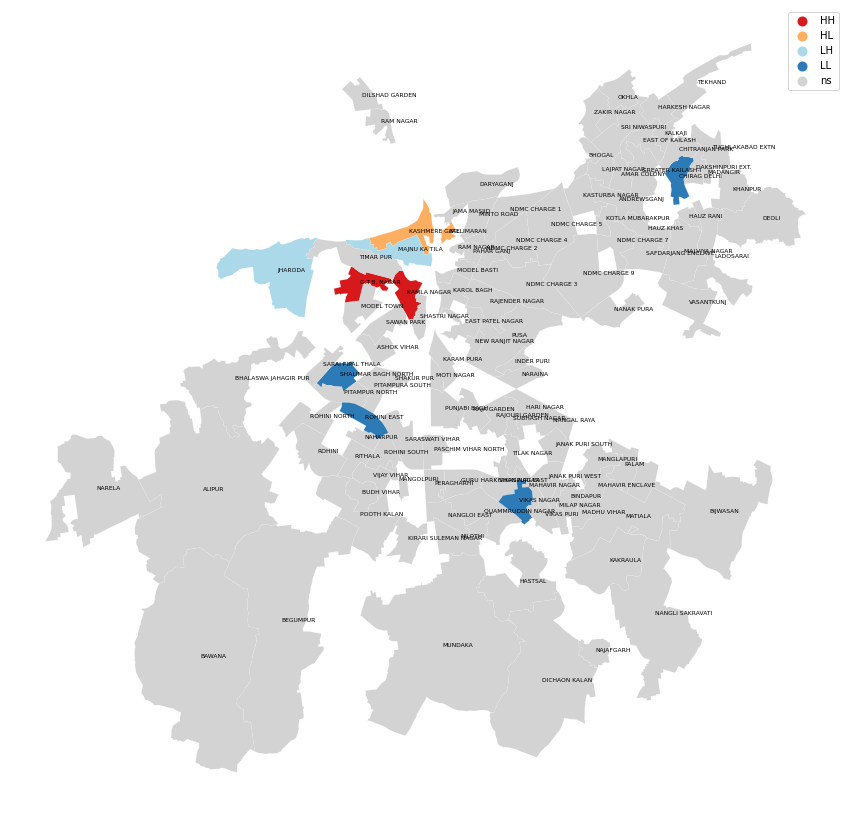

In [ ]:
#Visualising the clusters
texts = []

lisa_cluster(moran_loc_bv, spatial_dummy, p=0.05, figsize = (15,15))
for x, y, label in zip(delhi_points.geometry.x, delhi_points.geometry.y, delhi_points["Ward_Name"]):
    texts.append(plt.text(x, y, label, fontsize = 6))
plt.show()

In [ ]:
delhi.head()

,Unnamed: 0,incident_id,title,short_desc,date,location,tags,lat,lon,geom,locality,town,state,country,Ward_Name
0,0,incident_13635,Report on facebook,I'm a 58 year old woman and not used to seein...,2020-10-22 18:28:00,"Dhaula Kuan, Dhaula Kuan Enclave I, Dhaula Kua...",Indecent exposure,28.595638,77.162840,"28.5956381,77.16284040000001",New Delhi,NaN,Delhi,India,DELHI CANTT CHARGE 3
1,1,incident_13625,cyber bully,There is a facebook group of people who bully...,2020-06-21 11:45:00,"delhi green park 16 delhi green park 16, Pocke...",Online Harassment,28.704110,77.102489,"28.7041097,77.10248890000001",Delhi,NaN,Delhi,India,ROHINI SOUTH
2,7,incident_13616,Domestic Violence,My husband says bad words to me. doubts on my...,2020-05-11 15:00:00,"177, Okhla Head Rd, Okhla Village, Okhla, New ...",Domestic Violence,28.563690,77.291449,"28.5636896,77.29144889999998",New Delhi,NaN,Delhi,India,OKHLA
3,9,incident_13617,Domestic Violence,My husband and mother in law beat me. they do...,2020-04-27 22:00:00,"225, near Sundar Public School, Pocket C, Sari...",Domestic Violence,28.534882,77.297340,"28.534882500000002,77.29734049999998",New Delhi,NaN,Delhi,India,SARITA VIHAR
4,10,incident_13615,Domestic Violence,I am living with my parents in lockdown. They...,2020-04-08 10:38:00,"delhi green park 16 delhi green park 16, Pocke...",Domestic Violence,28.704110,77.102489,"28.7041097,77.10248890000001",Delhi,NaN,Delhi,India,ROHINI SOUTH


### Continued

## Descriptive analysis based on location and time

In [66]:
#Grouping incidents by locations and getting top 20 wards with most reported cases
location_counts = pd.DataFrame(delhi[['Ward_Name','incident_id']].groupby('Ward_Name').agg('count'))
location_counts['incident_id'].nlargest(20)

Ward_Name
NDMC CHARGE 4           439
MATIALA                 265
QASABPURA               180
NDMC CHARGE 1           164
TIMAR PUR               144
MILAP NAGAR             132
PAHAR GANJ              127
OKHLA                   124
KAKRAULA                109
BIJWASAN                106
KAMLA NAGAR              83
G.T.B. NAGAR             69
DELHI CANTT CHARGE 3     67
NANAK PURA               59
MADANGIR                 57
VASANT VIHAR             57
AMAR COLONY              54
MUNIRKA                  47
KASHMERE GATE            46
LADOSARAI                46
Name: incident_id, dtype: int64

In [11]:
#Wards with least reported incidents
location_counts['incident_id'].nsmallest(20)

Ward_Name
BHALASWA JAHAGIR PUR    1
BUDH VIHAR              1
DABRI                   1
DELHI CANTT CHARGE 7    1
DHARAMPURA              1
DICHAON KALAN           1
DURGA PURI              1
GANDHI NAGAR            1
GURU HARKISHAN NAGAR    1
HARKESH NAGAR           1
JAITPUR                 1
JHILMIL                 1
KARAM PURA              1
KUNWAR SINGH NAGAR      1
LAXMI NAGAR             1
MANGOL PURI  NORTH      1
MANGOLPURI              1
NANGLI SAKRAVATI        1
NILOTHI                 1
NIMRI COLONY            1
Name: incident_id, dtype: int64

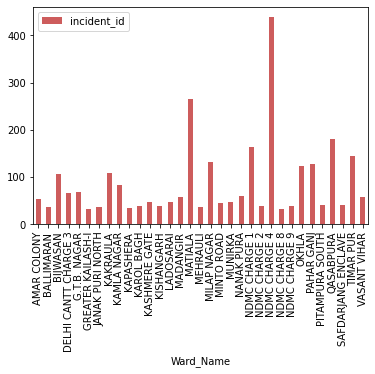

In [12]:
#Plotting locations with greater than 30 incidents
location_counts[location_counts['incident_id']>30].plot(kind="bar",color='indianred')

In [13]:
#Getting top 20 tags
tags_grouping = pd.DataFrame(delhi[['tags','incident_id']].groupby('tags').agg('count'))
tags_grouping['incident_id'].nlargest(20)

tags
Ogling/Facial Expressions/Staring    1139
Commenting                            910
Touching /Groping                     606
Catcalls/Whistles                     589
Taking pictures                       275
Others                                269
Chain Snatching / Robbery             183
Indecent exposure                     122
Sexual Invites                        115
Stalking                               62
Poor / No Street Lighting              58
Rape / Sexual Assault                  55
0                                      30
North East India Report                 6
Domestic Violence                       3
Online Harassment                       1
Name: incident_id, dtype: int64

In [14]:
#Mapping tags with each incident and displaying top 40
incident_location_grouping = pd.DataFrame(delhi[['Ward_Name','incident_id','tags']].groupby(['Ward_Name','tags']).agg('count'))
incident_location_grouping['incident_id'].nlargest(40)

Ward_Name             tags                             
NDMC CHARGE 4         Ogling/Facial Expressions/Staring    131
MATIALA               Ogling/Facial Expressions/Staring    122
NDMC CHARGE 4         Commenting                            92
                      Touching /Groping                     85
                      Catcalls/Whistles                     54
TIMAR PUR             Commenting                            47
NDMC CHARGE 1         Touching /Groping                     46
OKHLA                 Ogling/Facial Expressions/Staring     46
QASABPURA             Others                                46
MATIALA               Catcalls/Whistles                     45
MILAP NAGAR           Touching /Groping                     40
QASABPURA             Catcalls/Whistles                     39
NDMC CHARGE 4         Taking pictures                       36
NDMC CHARGE 1         Commenting                            35
                      Ogling/Facial Expressions/Staring     35

In [15]:
#Defining chart style for two categorical variables histogram visualisation
def stack_plot(data,col, target, ax=None):

    
    palette = ['#21618C','#AED6F1','#F39C12','#FAD7A0','#229954','#A9DFBF','#CD6155','#FDEDEC','#9B59B6','#D7BDE2','#9C640C','#B9770E','#797D7F','#BDC3C7','#C5D321','#F8FFA6','#1ED0BD','#B6F7F9','#B6B6F9','#4F4F90']

    counts = (data[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')
    props.plot(kind="barh", stacked=True,figsize=(20,20), color=palette)

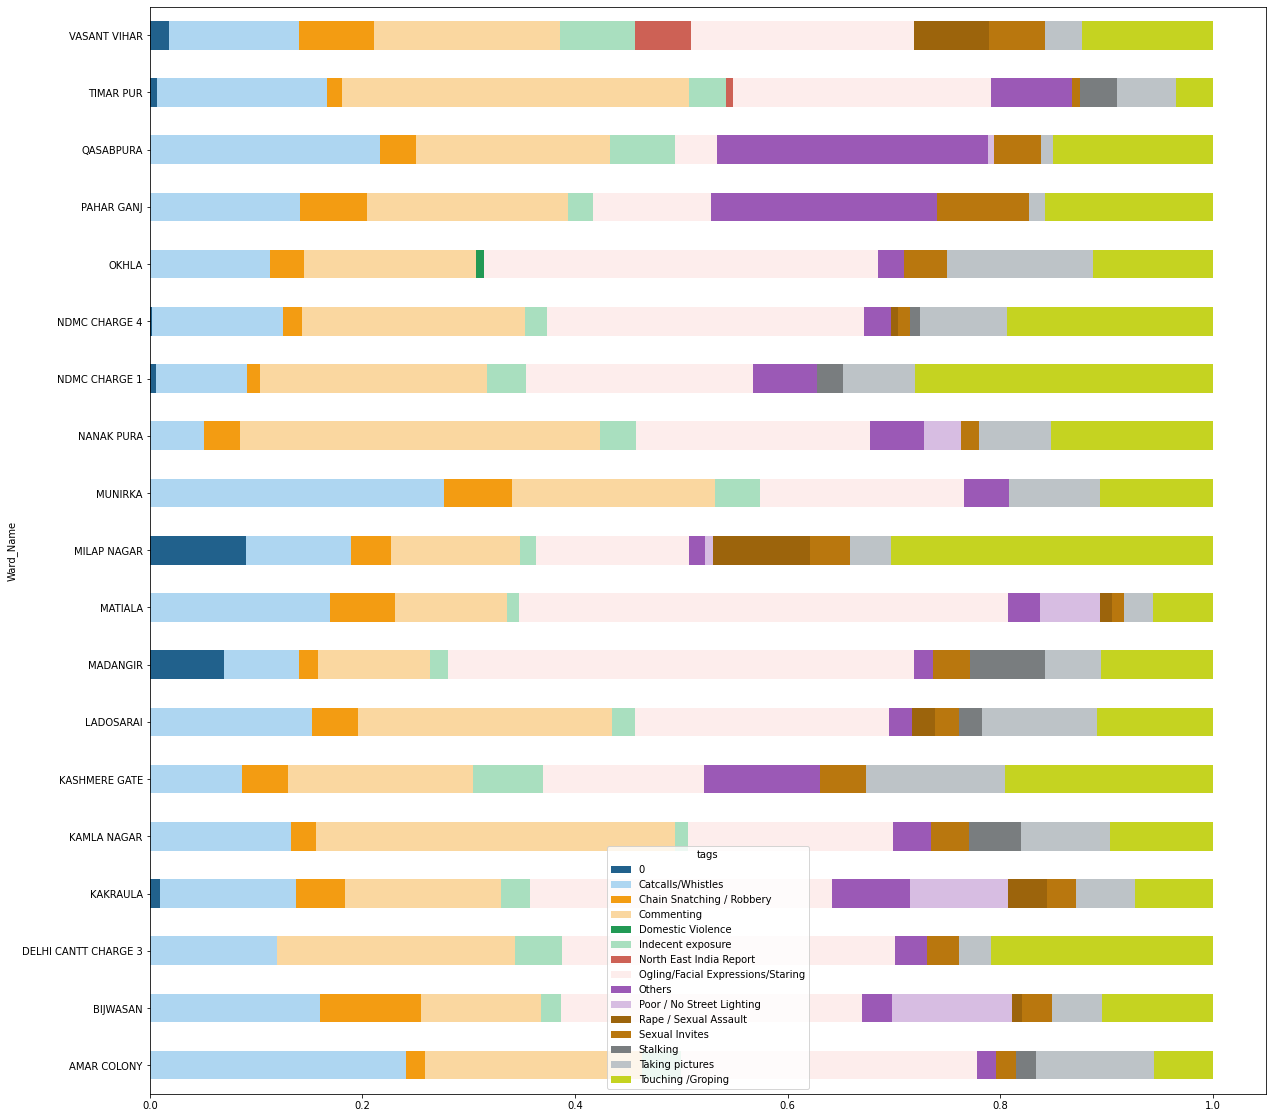

In [16]:
high_cases = ['NDMC CHARGE 4','MATIALA','QASABPURA','NDMC CHARGE 1','TIMAR PUR', 'MILAP NAGAR','PAHAR GANJ','OKHLA',
              'KAKRAULA','BIJWASAN','KAMLA NAGAR','G.T.B NAGAR','DELHI CANTT CHARGE 3','NANAK PURA','MADANGIR','VASANT VIHAR',
              'AMAR COLONY','MUNIRKA','KASHMERE GATE','LADOSARAI']
stack_plot(delhi[delhi['Ward_Name'].isin(high_cases)],'Ward_Name', 'tags')

In [17]:
# Creating Date, Hour, Month and Year Columns
delhi['date'] = pd.to_datetime(delhi['date'])
delhi['hour'] = delhi['date'].dt.hour
delhi['month'] = delhi['date'].dt.month
delhi['year'] = delhi['date'].dt.year
delhi['date_only'] = delhi['date'].dt.date
delhi.head()

,Unnamed: 0,incident_id,title,short_desc,date,location,tags,lat,lon,geom,locality,town,state,country,Ward_Name,hour,month,year,date_only
0,0,incident_13635,Report on facebook,I'm a 58 year old woman and not used to seein...,2020-10-22 18:28:00,"Dhaula Kuan, Dhaula Kuan Enclave I, Dhaula Kua...",Indecent exposure,28.595638,77.162840,"28.5956381,77.16284040000001",New Delhi,NaN,Delhi,India,DELHI CANTT CHARGE 3,18,10,2020,2020-10-22
1,1,incident_13625,cyber bully,There is a facebook group of people who bully...,2020-06-21 11:45:00,"delhi green park 16 delhi green park 16, Pocke...",Online Harassment,28.704110,77.102489,"28.7041097,77.10248890000001",Delhi,NaN,Delhi,India,ROHINI SOUTH,11,6,2020,2020-06-21
2,7,incident_13616,Domestic Violence,My husband says bad words to me. doubts on my...,2020-05-11 15:00:00,"177, Okhla Head Rd, Okhla Village, Okhla, New ...",Domestic Violence,28.563690,77.291449,"28.5636896,77.29144889999998",New Delhi,NaN,Delhi,India,OKHLA,15,5,2020,2020-05-11
3,9,incident_13617,Domestic Violence,My husband and mother in law beat me. they do...,2020-04-27 22:00:00,"225, near Sundar Public School, Pocket C, Sari...",Domestic Violence,28.534882,77.297340,"28.534882500000002,77.29734049999998",New Delhi,NaN,Delhi,India,SARITA VIHAR,22,4,2020,2020-04-27
4,10,incident_13615,Domestic Violence,I am living with my parents in lockdown. They...,2020-04-08 10:38:00,"delhi green park 16 delhi green park 16, Pocke...",Domestic Violence,28.704110,77.102489,"28.7041097,77.10248890000001",Delhi,NaN,Delhi,India,ROHINI SOUTH,10,4,2020,2020-04-08


In [18]:
#Visualising incidents as per dates
date_grouping = pd.DataFrame(delhi[['date_only','incident_id']].groupby('date_only').agg('count')).sort_values('incident_id')
date_grouping['incident_id'].nlargest(20)

date_only
2015-09-25    330
2014-02-08    225
2015-02-21    193
2014-01-18    172
2013-11-06    132
2013-11-15    122
2013-10-09    114
2013-10-19     95
2015-02-22     94
2013-10-08     90
2015-03-06     85
2014-02-23     80
2014-02-22     75
2014-04-13     68
2014-01-19     68
2015-05-27     66
2013-09-30     66
2015-02-20     64
2014-04-12     60
2015-05-26     59
Name: incident_id, dtype: int64

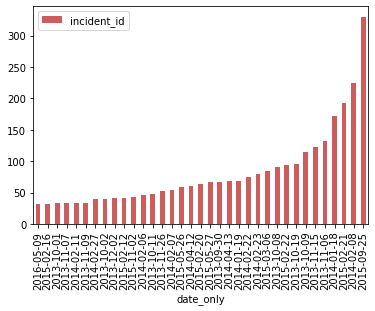

In [19]:
#Plotting locations with greater than 30 incidents
date_grouping[date_grouping['incident_id']>30].plot(kind="bar",color='indianred')

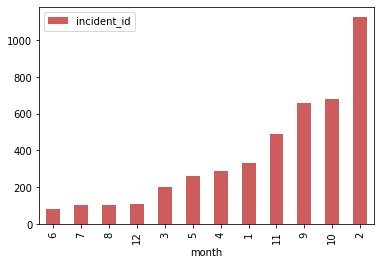

In [20]:
#Visualising incidents as per months
month_grouping = pd.DataFrame(delhi[['month','incident_id']].groupby('month').agg('count')).sort_values('incident_id')
month_grouping.plot(kind="bar",color='indianred')

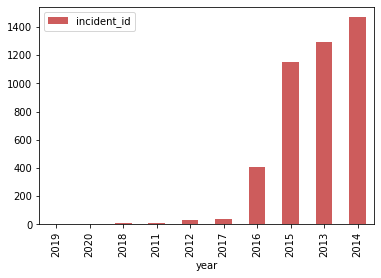

In [21]:
#Visualising incidents as per years
year_grouping = pd.DataFrame(delhi[['year','incident_id']].groupby('year').agg('count')).sort_values('incident_id')
year_grouping.plot(kind="bar",color='indianred')

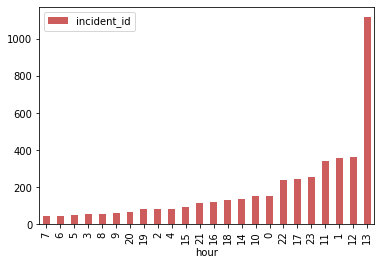

In [22]:
#Visualising incidents as per hours
hour_grouping = pd.DataFrame(delhi[['hour','incident_id']].groupby('hour').agg('count')).sort_values('incident_id')
hour_grouping.plot(kind="bar",color='indianred')

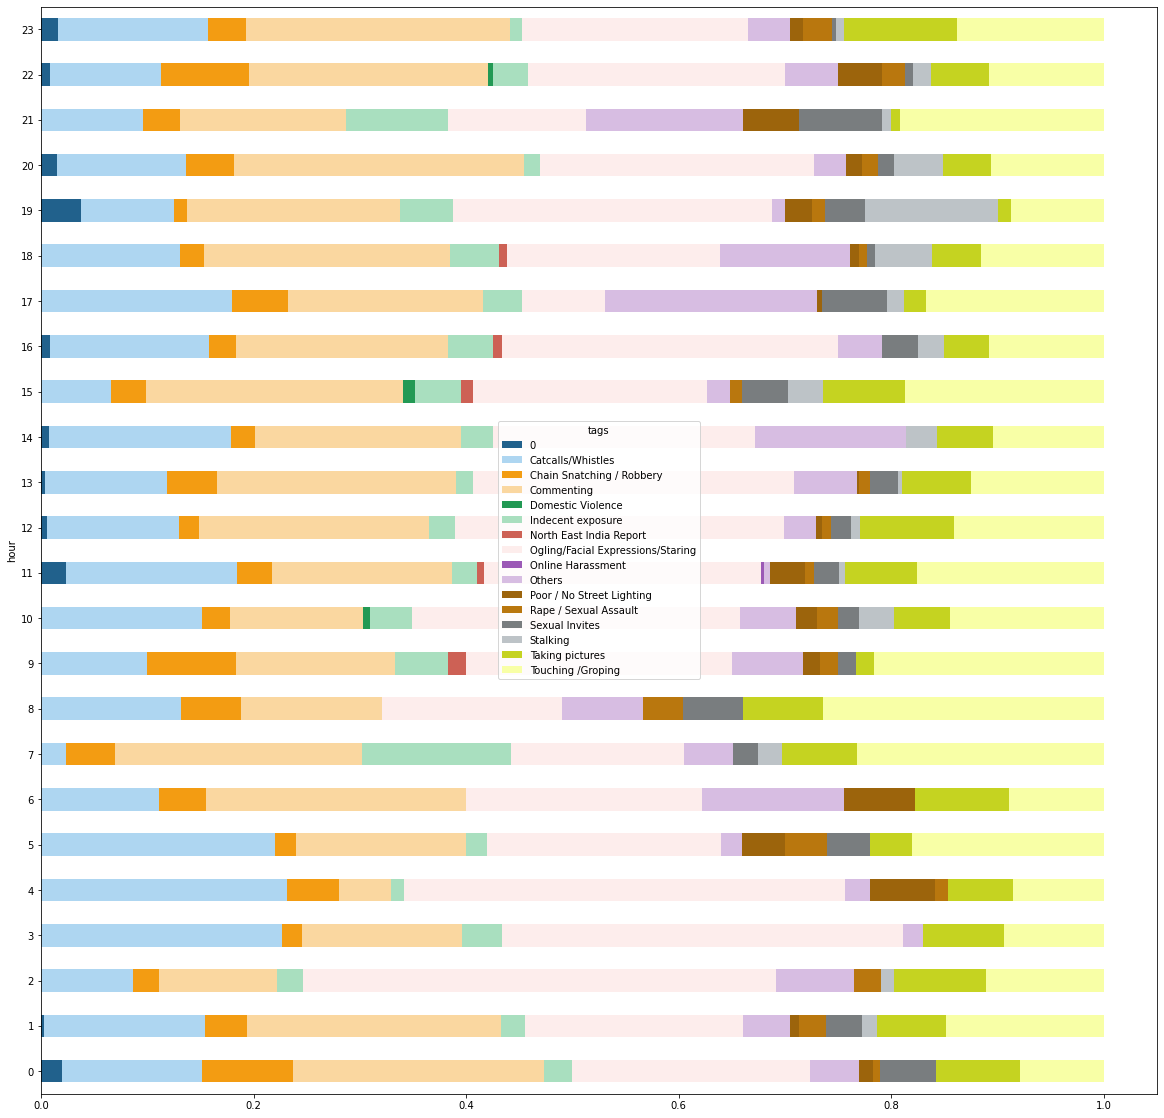

In [23]:
#Visualising tags by hours
stack_plot(delhi,"hour","tags")

In [24]:
#Assigning a new column with time bin for each incident for better visualisations
def time_bin(row):
  if 8 <= row['hour'] <= 11:
    val = 'Morning'
  elif 12 <= row['hour'] <= 15:
    val = 'Noon'
  elif 16 <= row['hour'] <= 19:
    val = 'Evening'
  elif 19 <= row['hour'] <= 23:
    val = 'Night'
  elif 0 <= row['hour'] <= 4:
    val = 'Late Night'
  elif 5 <= row['hour'] <= 7:
    val = 'Early Morning'
  else:
    val = 'Not Assigned'

  return val

delhi['time_bin'] = delhi.apply(time_bin, axis=1)

delhi.head(10)

,Unnamed: 0,incident_id,title,short_desc,date,location,tags,lat,lon,geom,locality,town,state,country,Ward_Name,hour,month,year,date_only,time_bin
0,0,incident_13635,Report on facebook,I'm a 58 year old woman and not used to seein...,2020-10-22 18:28:00,"Dhaula Kuan, Dhaula Kuan Enclave I, Dhaula Kua...",Indecent exposure,28.595638,77.162840,"28.5956381,77.16284040000001",New Delhi,NaN,Delhi,India,DELHI CANTT CHARGE 3,18,10,2020,2020-10-22,Evening
1,1,incident_13625,cyber bully,There is a facebook group of people who bully...,2020-06-21 11:45:00,"delhi green park 16 delhi green park 16, Pocke...",Online Harassment,28.704110,77.102489,"28.7041097,77.10248890000001",Delhi,NaN,Delhi,India,ROHINI SOUTH,11,6,2020,2020-06-21,Morning
2,7,incident_13616,Domestic Violence,My husband says bad words to me. doubts on my...,2020-05-11 15:00:00,"177, Okhla Head Rd, Okhla Village, Okhla, New ...",Domestic Violence,28.563690,77.291449,"28.5636896,77.29144889999998",New Delhi,NaN,Delhi,India,OKHLA,15,5,2020,2020-05-11,Noon
3,9,incident_13617,Domestic Violence,My husband and mother in law beat me. they do...,2020-04-27 22:00:00,"225, near Sundar Public School, Pocket C, Sari...",Domestic Violence,28.534882,77.297340,"28.534882500000002,77.29734049999998",New Delhi,NaN,Delhi,India,SARITA VIHAR,22,4,2020,2020-04-27,Night
4,10,incident_13615,Domestic Violence,I am living with my parents in lockdown. They...,2020-04-08 10:38:00,"delhi green park 16 delhi green park 16, Pocke...",Domestic Violence,28.704110,77.102489,"28.7041097,77.10248890000001",Delhi,NaN,Delhi,India,ROHINI SOUTH,10,4,2020,2020-04-08,Morning
5,31,incident_12237,Snatching of mobile,I was talking by mobile near popular juice in...,2019-09-16 18:00:00,"78, Bada Bazar Rd, Block 54, Rajinder Nagar, N...",Others,28.640485,77.184609,"28.640484999999998,77.184609",New Delhi,NaN,Delhi,India,RAJENDER NAGAR,18,9,2019,2019-09-16,Evening
6,32,incident_12236,Snatching of mobile,I was talking by mobile near popular juice in...,2019-09-16 18:00:00,"78, Bada Bazar Rd, Block 54, Rajinder Nagar, N...",Others,28.640485,77.184609,"28.640484999999998,77.184609",New Delhi,NaN,Delhi,India,RAJENDER NAGAR,18,9,2019,2019-09-16,Evening
7,53,incident_13162,Groped,Groped on a bus \n\t\t\t\t\t\t More Informa...,2019-06-14 16:00:00,"Unnamed Road, Mayapuri Industrial Area Phase I...",Ogling/Facial Expressions/Staring,28.612081,77.112533,"28.612080600000002,77.1125325",New Delhi,NaN,Delhi,India,NANGAL RAYA,16,6,2019,2019-06-14,Evening
8,88,incident_12107,Inappropriate comments when inerviewed,During the course of the interview the MD ask...,2019-04-09 17:00:00,"308,DLF South Court, Saket",Commenting,28.527926,77.220591,"28.5279261,77.2205915",New Delhi,NaN,Delhi,India,LADOSARAI,17,4,2019,2019-04-09,Evening
9,518,incident_11518,Kissing sounds,Two men on motorcycle made kisisng sounds whi...,2018-07-08 19:00:00,"Kirormal College, Delhi School Of Economics, U...",Ogling/Facial Expressions/Staring,28.683789,77.208076,"28.683789,77.20807599999998",Delhi,NaN,Delhi,India,TIMAR PUR,19,7,2018,2018-07-08,Evening


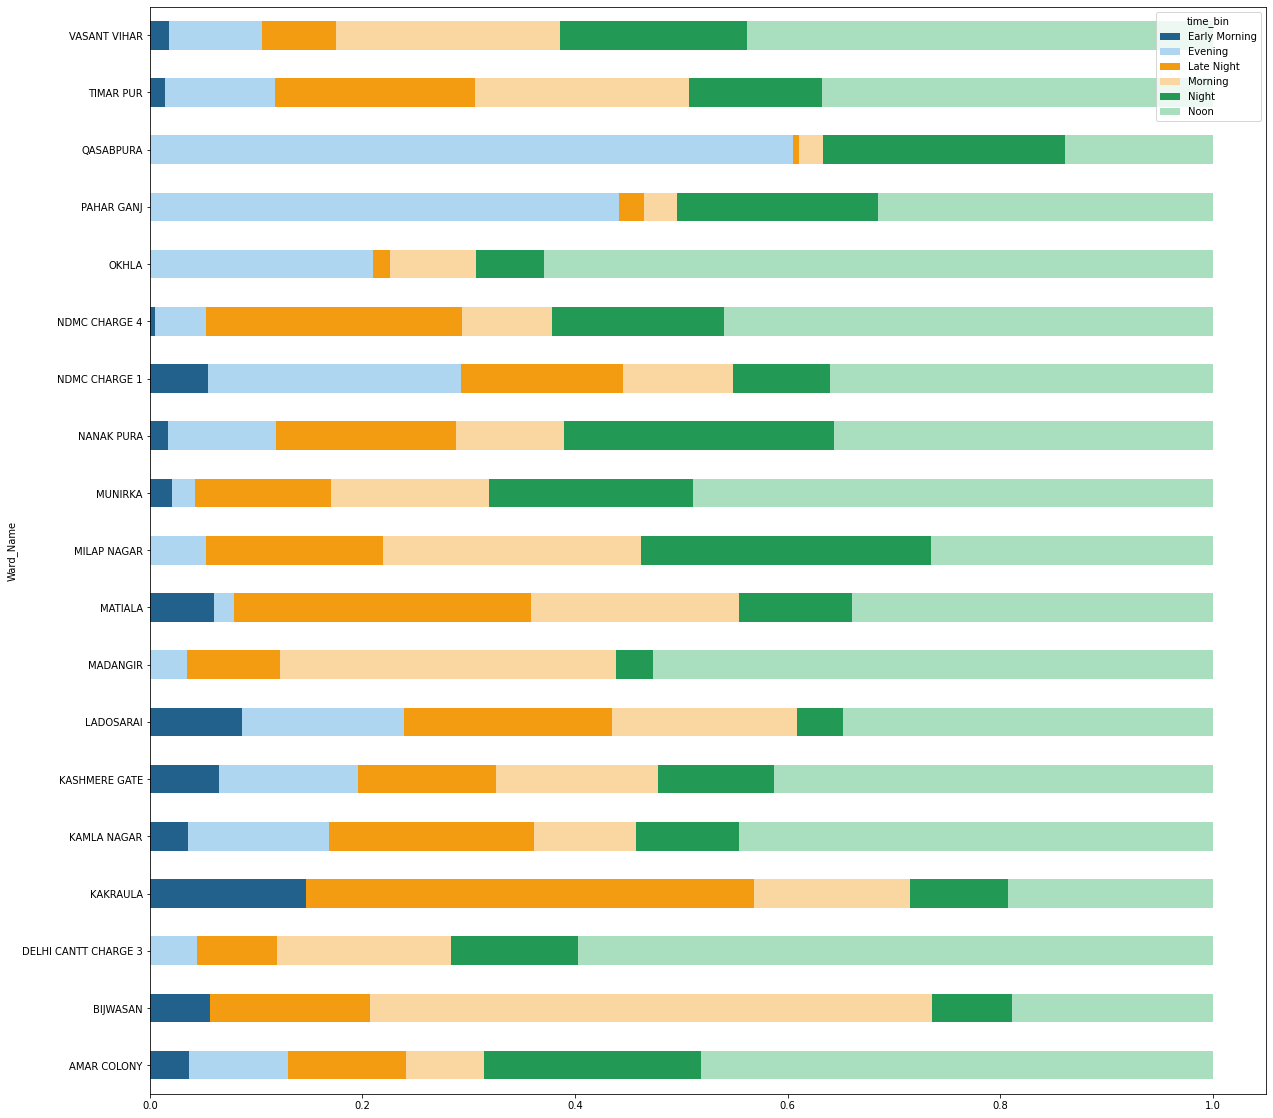

In [25]:
#Plotting cases in each location against time bins
stack_plot(delhi[delhi['Ward_Name'].isin(high_cases)],'Ward_Name', 'time_bin')

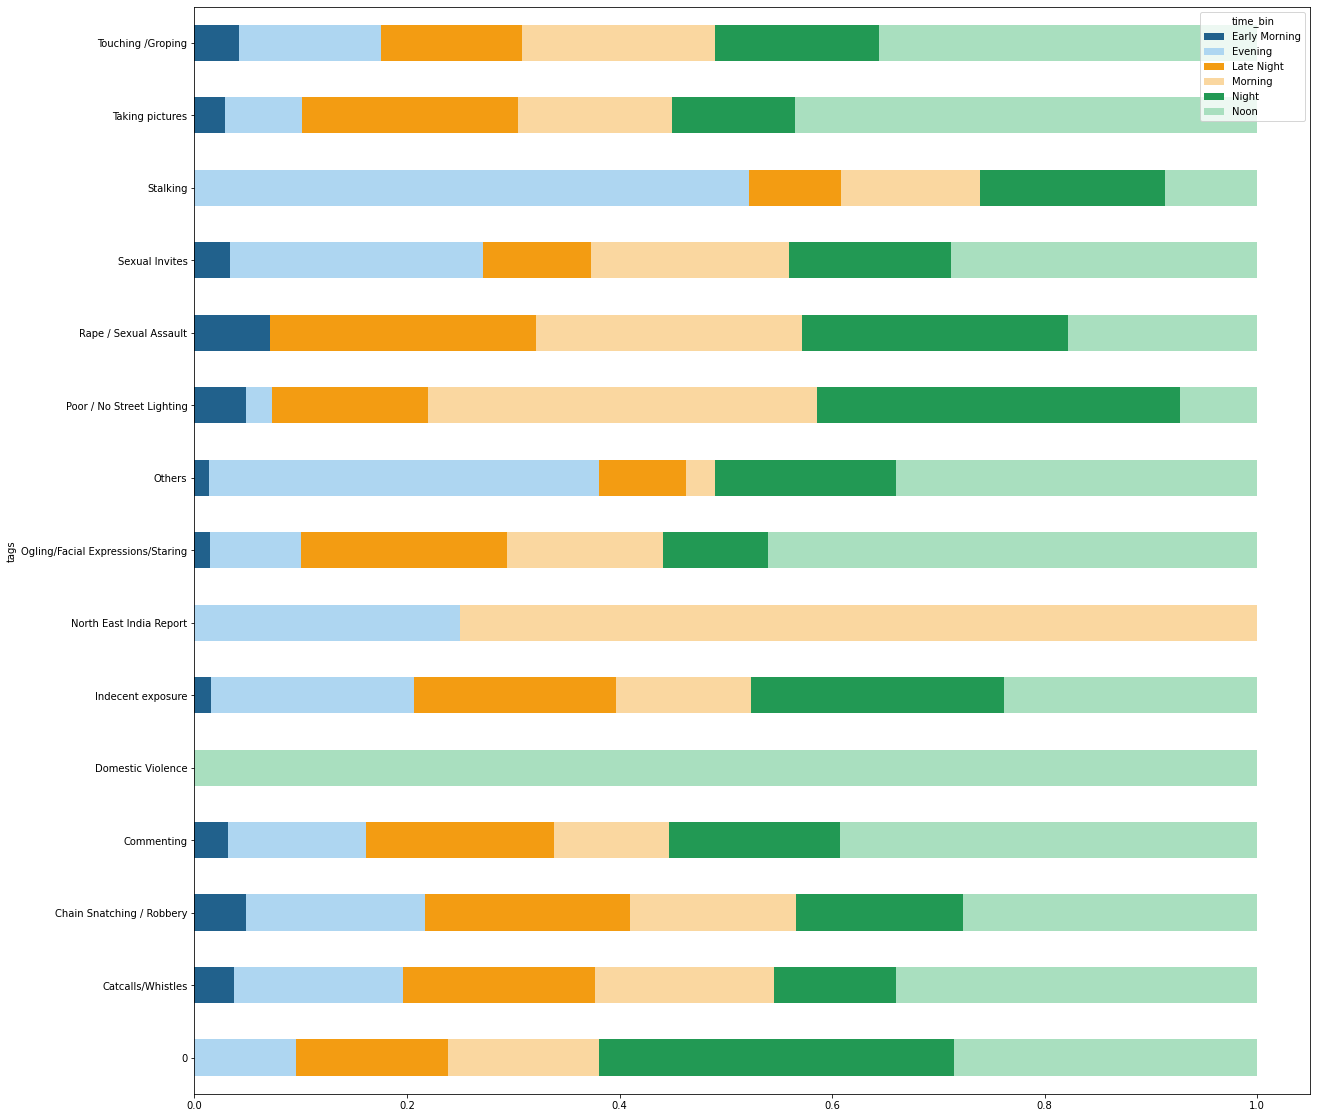

In [26]:
stack_plot(delhi[delhi['Ward_Name'].isin(high_cases)],'tags', 'time_bin')

## Mapping 

In [27]:
#Generating a base map for Delhi
def generateBaseMap(default_location=[28.612867406287382, 77.20721469951079], default_zoom_start=11):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [28]:
#Creating a heatmap of incidents across Delhi
delhi_copy = delhi.copy()
delhi_copy['count'] = 1
base_map = generateBaseMap()
steps = 5
color_map=cm.linear.Paired_11.scale(0,1).to_step(steps)
gradient_map= {}
for i in range(steps):
    gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)
HeatMap(data=delhi_copy[['lat', 'lon', 'count']].groupby(['lat', 'lon']).sum().reset_index().values.tolist(), radius=8, max_zoom=11,gradient=gradient_map).add_to(base_map)
display(base_map)

In [29]:
#Visualising cases per hour on the basemap
df_hour_list = []
delhi_copy['date'] = pd.to_datetime(delhi_copy['date'])
delhi_copy['hour'] = delhi_copy['date'].dt.hour
for hour in delhi_copy.hour.sort_values().unique():
    df_hour_list.append(delhi_copy.loc[delhi_copy.hour == hour, ['lat', 'lon', 'count']].groupby(['lat', 'lon']).sum().reset_index().values.tolist())

In [30]:
#Generating incidents heatmap with time
base_map = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

In [31]:
#Resetting index
location_counts.reset_index()

,Ward_Name,incident_id
0,ADARASH NAGAR,17
1,ALIPUR,3
2,AMAR COLONY,54
3,AMBEDKAR NAGAR,10
4,ANAND VIHAR,12
...,...,...
216,VIVEK VIHAR,8
217,WAJIRPUR,6
218,WEST PATEL NAGAR,14
219,YAMUNA VIHAR,5


In [32]:
#Merging spatial data
delhi_wards_cases = delhi_wards.merge(location_counts,on='Ward_Name',how='inner')
delhi_wards_cases.head()

,Ward_Name,Ward_No,geometry,incident_id
0,DELHI CANTT CHARGE 1,CANT_1,"POLYGON ((29356131.178 28902372.508, 29359930....",3
1,DELHI CANTT CHARGE 4,CANT_4,"POLYGON ((29375328.819 28913751.798, 29375422....",7
2,DELHI CANTT CHARGE 6,CANT_6,"POLYGON ((29370794.406 28901102.271, 29371452....",5
3,DELHI CANTT CHARGE 7,CANT_7,"POLYGON ((29370794.406 28901102.271, 29370374....",1
4,DELHI CANTT CHARGE 3,CANT_3,"POLYGON ((29364687.045 28915999.728, 29366222....",67


In [33]:
#Visualising chloropeth
colormap = cm.linear.YlGnBu_09.to_step(data=delhi_wards_cases['incident_id'], method='quant', quantiles=[0,0.1,0.3,0.5,0.75,0.9,0.98,1])
base_map = generateBaseMap()
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(base_map)
colormap.caption = "Number of incidents"
style_function = lambda x: {"weight":0.5, 
                            'color':'black',
                            'fillColor':colormap(x['properties']['incident_id']), 
                            'fillOpacity':0.75}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL=folium.features.GeoJson(
        delhi_wards_cases,
        style_function=style_function,
        control=False,
        highlight_function=highlight_function,
        tooltip=folium.features.GeoJsonTooltip(fields=['Ward_Name','incident_id'],
            aliases=['Neighborhood','Number of incidents'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
            sticky=True
        )
    )
colormap.add_to(base_map)
base_map.add_child(NIL)
base_map

### Spatial Correlations of incidents - Hot Spot Analysis

In [47]:
# Normalising cases as per spatial area
del delhi_wards_cases['normalised_cases']
delhi_wards_cases['normalised_incidents'] = delhi_wards_cases['incident_id']/delhi_wards_cases.area
delhi_wards_cases.head()

,Ward_Name,Ward_No,geometry,incident_id,normalised_incidents
0,DELHI CANTT CHARGE 1,CANT_1,"POLYGON ((29356131.178 28902372.508, 29359930....",3,2.094703e-07
1,DELHI CANTT CHARGE 4,CANT_4,"POLYGON ((29375328.819 28913751.798, 29375422....",7,7.429749e-08
2,DELHI CANTT CHARGE 6,CANT_6,"POLYGON ((29370794.406 28901102.271, 29371452....",5,2.917470e-08
3,DELHI CANTT CHARGE 7,CANT_7,"POLYGON ((29370794.406 28901102.271, 29370374....",1,2.290104e-08
4,DELHI CANTT CHARGE 3,CANT_3,"POLYGON ((29364687.045 28915999.728, 29366222....",67,1.172652e-06


In [49]:
# Incidents after 
location_counts_normalised = pd.DataFrame(delhi_wards_cases[['Ward_Name','normalised_incidents']].groupby('Ward_Name').agg('sum'))
location_counts_normalised['normalised_incidents'].nlargest(20)

Ward_Name
QASABPURA           0.000021
PAHAR GANJ          0.000011
MADANGIR            0.000010
NDMC CHARGE 4       0.000009
MILAP NAGAR         0.000008
BALLIMARAN          0.000006
NDMC CHARGE 1       0.000004
MUNIRKA             0.000003
KAMLA NAGAR         0.000003
OKHLA               0.000003
NDMC CHARGE 8       0.000003
TIMAR PUR           0.000003
AMAR COLONY         0.000003
G.T.B. NAGAR        0.000002
HAUZ RANI           0.000002
MATIALA             0.000002
NDMC CHARGE 2       0.000002
DAKSHINPURI EXT.    0.000002
AMBEDKAR NAGAR      0.000002
NANAK PURA          0.000002
Name: normalised_incidents, dtype: float64

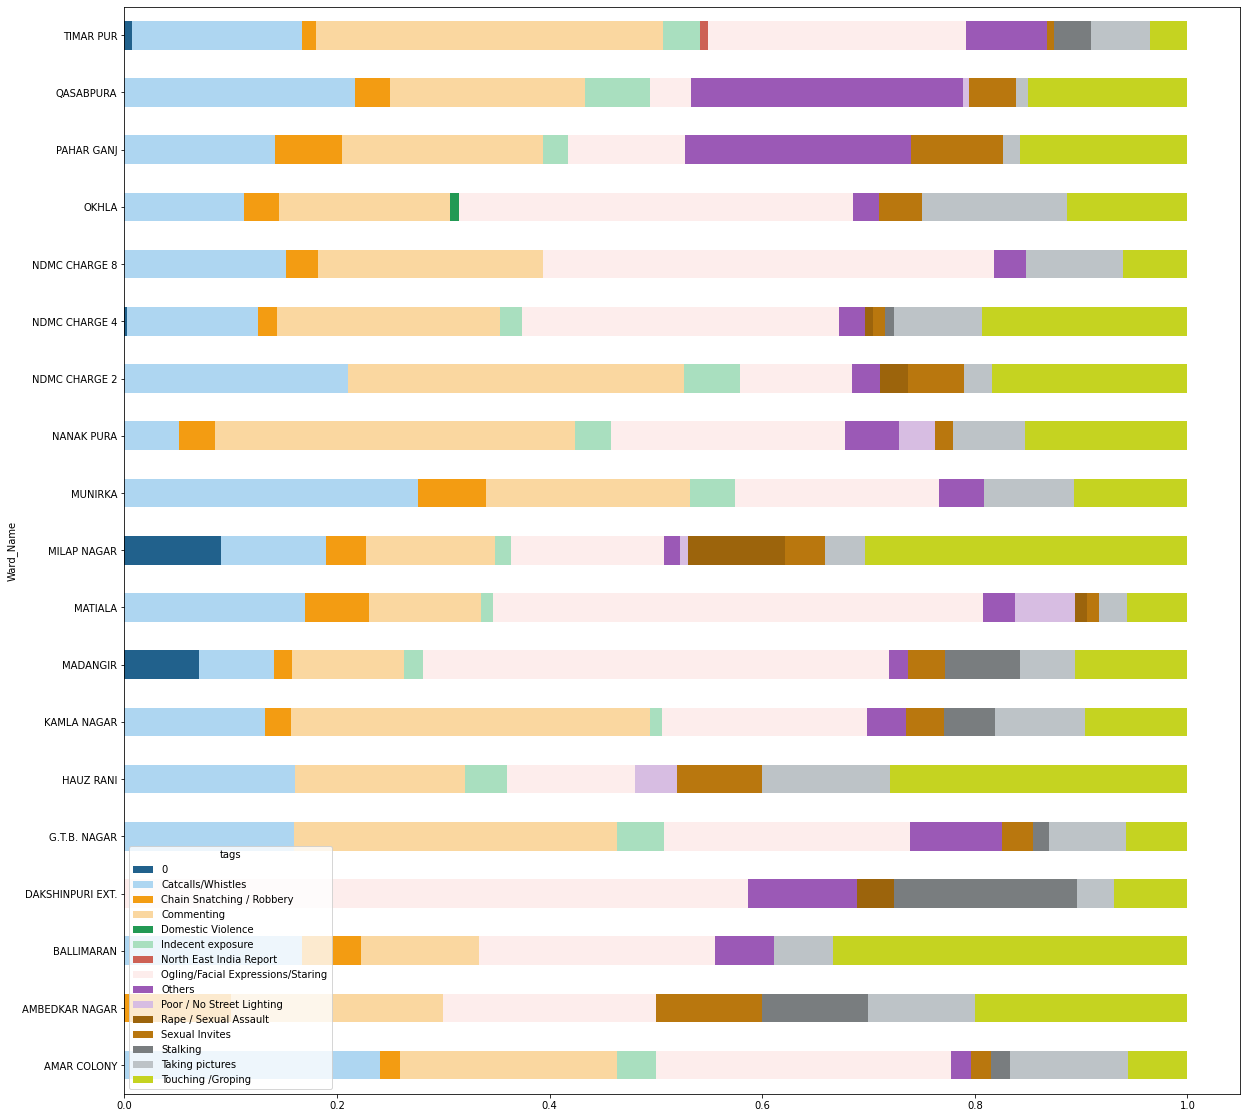

In [67]:
# Visualising tags for locations with high cases after normalising
high_cases_normalised = ['QASABPURA','PAHAR GANJ','MADANGIR','NDMC CHARGE 4','MILAP NAGAR', 'BALLIMARAN','NDMC CHARGE 1 ','MUNIRKA',
              'KAMLA NAGAR','OKHLA','NDMC CHARGE 8','TIMAR PUR','AMAR COLONY','G.T.B. NAGAR','HAUZ RANI','MATIALA',
              'NDMC CHARGE 2','DAKSHINPURI EXT.','AMBEDKAR NAGAR','NANAK PURA']
stack_plot(delhi[delhi['Ward_Name'].isin(high_cases_normalised)],'Ward_Name', 'tags')

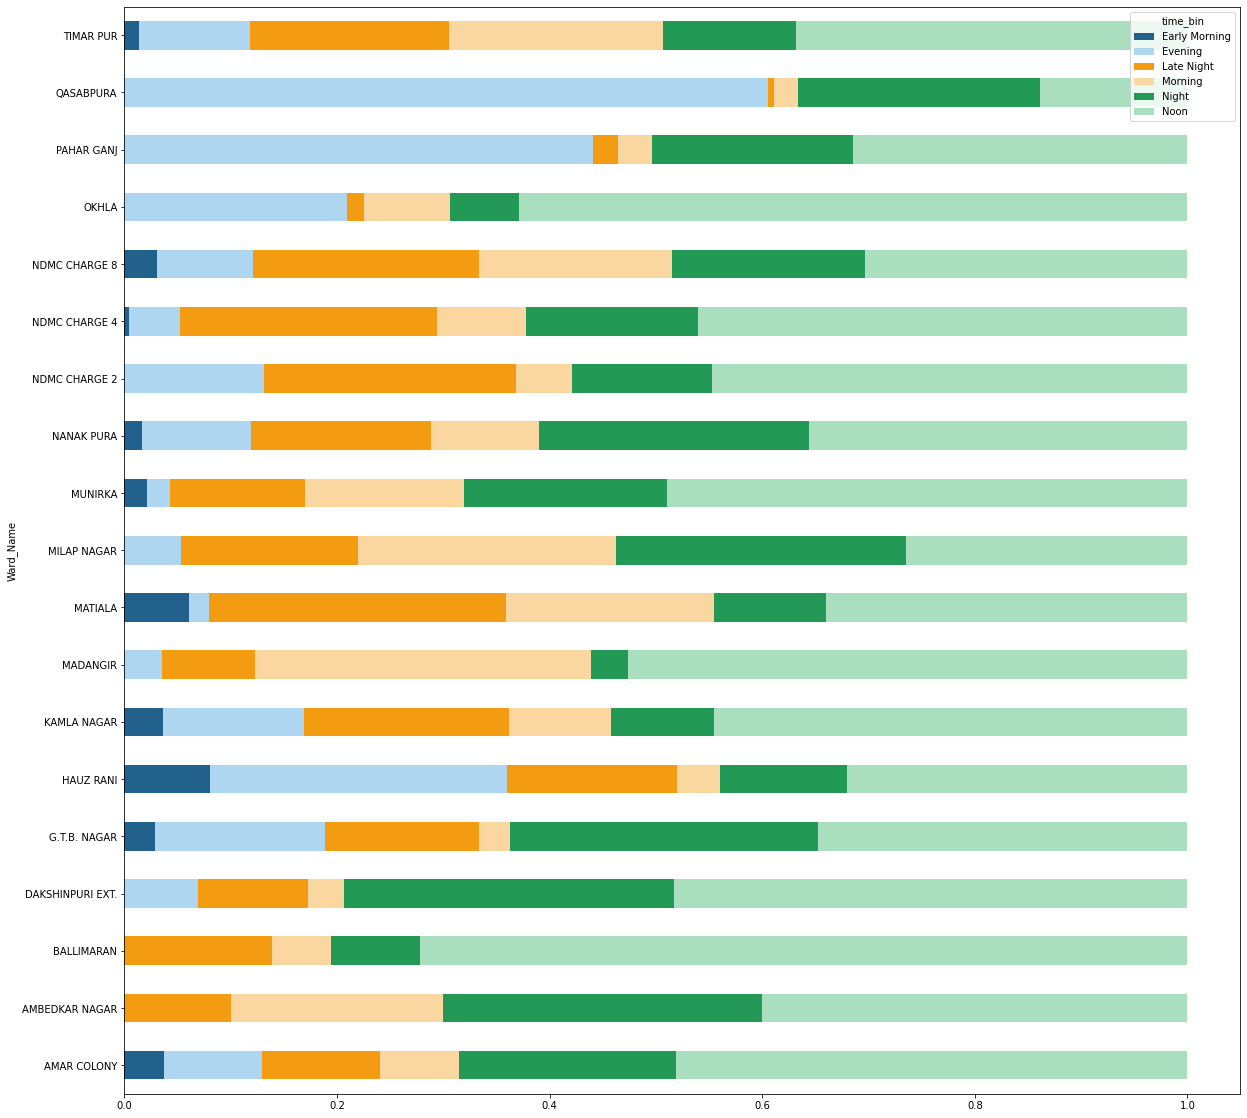

In [68]:
stack_plot(delhi[delhi['Ward_Name'].isin(high_cases_normalised)],'Ward_Name', 'time_bin')

In [69]:
#Calculating spatial correlation for incidents to see if there are clustered together
t = ['GOKALPUR','SHIV VIHAR','JAITPUR']
spatial_dummy = delhi_wards_cases.dropna(subset=['incident_id'])
spatial_dummy = spatial_dummy.loc[~spatial_dummy.Ward_Name.isin(t)]
y = spatial_dummy['incident_id'].values
w = Queen.from_dataframe(spatial_dummy)
w.transform = 'R'
moran = Moran(y,w)
moran_loc = Moran_Local(y, w, permutations=99)
moran.I

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


0.14583237516663697

In [70]:
#Creating points for label on maps
spatial_dummy["center"] = spatial_dummy["geometry"].centroid
delhi_points = spatial_dummy.copy()
delhi_points.set_geometry("center", inplace = True)

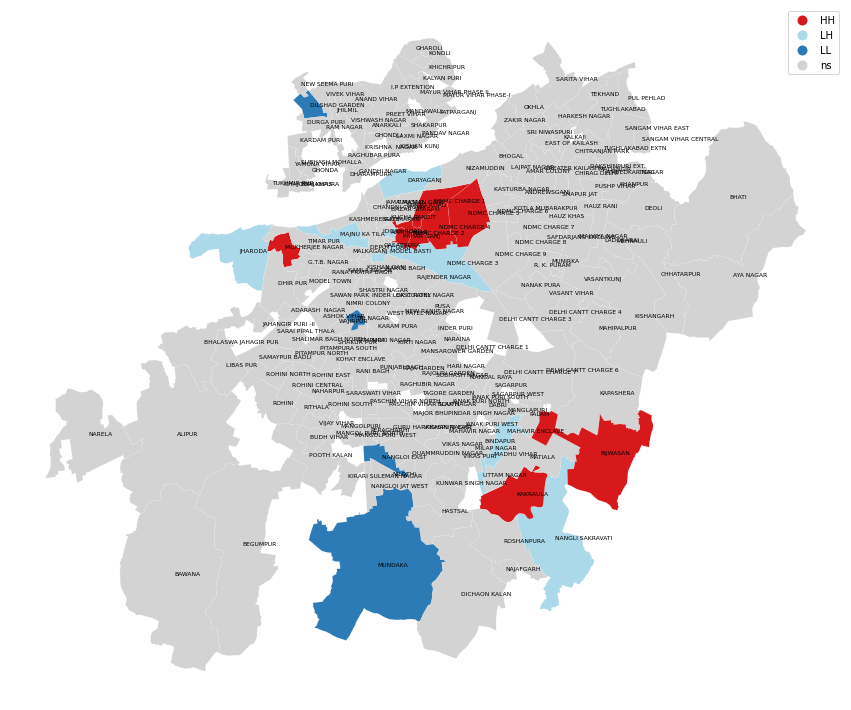

In [71]:
#Visualising the clusters
texts = []

lisa_cluster(moran_loc, spatial_dummy, p=0.05, figsize = (15,15))
for x, y, label in zip(delhi_points.geometry.x, delhi_points.geometry.y, delhi_points["Ward_Name"]):
    texts.append(plt.text(x, y, label, fontsize = 6))
plt.show()

In [72]:
#Adding a column for cluster values
spatial_dummy['cluster'] = moran_loc.q 

In [73]:
#Visualising locations with high spatially correlated incidents
spatial_dummy[spatial_dummy['cluster']==1]

,Ward_Name,Ward_No,geometry,incident_id,normalised_incidents,center,cluster
4,DELHI CANTT CHARGE 3,CANT_3,"POLYGON ((29364687.045 28915999.728, 29366222....",67,1.172652e-06,POINT (29369432.692 28909071.976),1
5,NDMC CHARGE 1,NDMC_1,"POLYGON ((29349783.878 28931281.735, 29350155....",164,3.702559e-06,POINT (29354964.892 28935269.690),1
6,NDMC CHARGE 2,NDMC_2,"POLYGON ((29346135.643 28931120.909, 29346500....",38,1.838598e-06,POINT (29350450.922 28928108.813),1
8,NDMC CHARGE 4,NDMC_4,"POLYGON ((29358009.905 28935272.734, 29358035....",439,8.929571e-06,POINT (29356088.087 28929519.999),1
9,NDMC CHARGE 5,NDMC_5,"POLYGON ((29358009.905 28935272.734, 29358160....",23,2.569845e-07,POINT (29362529.549 28932600.704),1
11,NDMC CHARGE 8,NDMC_8,"POLYGON ((29371262.422 28927581.044, 29372515....",33,2.714181e-06,POINT (29372927.749 28926136.827),1
12,NDMC CHARGE 9,NDMC_9,"POLYGON ((29362559.582 28925356.873, 29362660....",38,3.070126e-07,POINT (29368433.719 28923446.364),1
15,MINTO ROAD,81,"POLYGON ((29346697.789 28932734.900, 29346895....",44,1.549642e-06,POINT (29349132.910 28934345.081),1
20,MUKHERJEE NAGAR,11,"POLYGON ((29318529.925 28926624.990, 29318690....",20,6.894077e-07,POINT (29321979.009 28925000.874),1
25,KAKRAULA,135,"POLYGON ((29365442.046 28869686.214, 29365372....",109,9.909148e-07,POINT (29373330.180 28870255.008),1


In [74]:
#Visualising locations with low outliers 
spatial_dummy[spatial_dummy['cluster']==2]

,Ward_Name,Ward_No,geometry,incident_id,normalised_incidents,center,cluster
1,DELHI CANTT CHARGE 4,CANT_4,"POLYGON ((29375328.819 28913751.798, 29375422....",7,7.429749e-08,POINT (29380566.064 28910587.044),2
2,DELHI CANTT CHARGE 6,CANT_6,"POLYGON ((29370794.406 28901102.271, 29371452....",5,2.917470e-08,POINT (29379878.424 28897847.482),2
7,NDMC CHARGE 3,NDMC_3,"POLYGON ((29348449.603 28924754.510, 29348825....",9,8.918079e-08,POINT (29357843.765 28921455.716),2
10,NDMC CHARGE 7,NDMC_7,"POLYGON ((29371028.637 28931025.010, 29373000....",17,4.998147e-07,POINT (29374788.555 28929566.360),2
13,NDMC CHARGE 6,NDMC_6,"POLYGON ((29370783.780 28934518.018, 29371028....",5,3.281332e-07,POINT (29368981.068 28933011.416),2
16,KUCHA PANDIT,82,"POLYGON ((29344857.278 28931918.713, 29345941....",3,7.880734e-07,POINT (29345518.940 28931766.857),2
18,IDGAH ROAD,85,"POLYGON ((29342268.011 28928297.542, 29342187....",2,2.299416e-07,POINT (29343805.545 28928606.317),2
21,JANAK PURI WEST,117,"POLYGON ((29358767.402 28886082.355, 29359185....",12,4.691904e-07,POINT (29362010.754 28885809.091),2
24,NANGLI SAKRAVATI,134,"POLYGON ((29373400.715 28865977.071, 29373788....",1,4.032567e-09,POINT (29381849.591 28860498.333),2
30,RAM NAGAR,87,"POLYGON ((29346554.134 28929529.615, 29347042....",2,4.196062e-07,POINT (29345410.525 28928353.130),2


In [75]:
len(moran_loc.q)

219

In [76]:
spatial_dummy.shape

(219, 7)

### Visualising cases in sub-locations

#### Visualising reports in NDMC Charge 4

In [77]:
delhi_copy = delhi.copy()
delhi_copy['count'] = 1
base_map = generateBaseMap(default_zoom_start=12)
steps = 5
HeatMap(data=delhi_copy[delhi_copy['Ward_Name']=='NDMC CHARGE 4'][['lat', 'lon', 'count']].groupby(['lat', 'lon']).sum().reset_index().values.tolist(), radius=8, max_zoom=5).add_to(base_map)
display(base_map)

In [78]:
delhi_copy[delhi_copy['Ward_Name']=='NDMC CHARGE 4']

,Unnamed: 0,incident_id,title,short_desc,date,location,tags,lat,lon,geom,locality,town,state,country,Ward_Name,hour,month,year,date_only,time_bin,count
57,1362,incident_10801,Harassment,"Staring, passing comments \n\t\t\t\t\t\t Mo...",2017-01-14 16:00:00,"Gokul Nagar, Pandit Pant Marg Area, Central Se...",Catcalls/Whistles,28.618904,77.208180,"28.618903600000003,77.20818009999998",New Delhi,NaN,Delhi,India,NDMC CHARGE 4,16,1,2017,2017-01-14,Evening,1
74,1397,incident_10799,harassment,was victim of sxual assault RAPE \n\t\t\t\t\...,2016-12-22 22:00:00,"Connaught Place, New Delhi, Delhi 110001, India",Rape / Sexual Assault,28.630420,77.217722,"28.630420299999997,77.21772159999998",New Delhi,NaN,Delhi,India,NDMC CHARGE 4,22,12,2016,2016-12-22,Night,1
128,1701,incident_10066,case of stalking,i was stalked by a man while i was at the CS ...,2016-09-16 11:00:00,"Central Secretariat Metro Station, Rajpath Are...",Stalking,28.615151,77.212263,"28.6151511,77.21226349999998",New Delhi,NaN,Delhi,India,NDMC CHARGE 4,11,9,2016,2016-09-16,Morning,1
192,1856,incident_9965,LGBT,A police man was behaving in inappropriate wa...,2016-08-08 21:00:00,"Hanuman Road Area, Connaught Place, New Delhi,...",Sexual Invites,28.627917,77.212492,"28.6279168,77.21249190000002",New Delhi,NaN,Delhi,India,NDMC CHARGE 4,21,8,2016,2016-08-08,Night,1
221,1950,incident_10373,Harassment,a boy was commenting in the metro \n\t\t\t\t...,2016-07-05 14:00:00,"Central Secretariat Metro Station, Rafi Ahmed ...",Commenting,28.615151,77.212263,"28.6151511,77.21226349999998",New Delhi,NaN,Delhi,India,NDMC CHARGE 4,14,7,2016,2016-07-05,Noon,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4367,11310,incident_164,Chattarpur metro station harassment,The new guys working at Chattarpur metro stat...,2013-01-20 20:34:00,"New Delhi, Delhi, India",0,28.613939,77.209021,"28.6139391,77.20902120000001",New Delhi,NaN,Delhi,India,NDMC CHARGE 4,20,1,2013,2013-01-20,Night,1
4376,11395,incident_57,Sad but true - I am a woman and I feel unsafe...,I think there is no woman who has not gone th...,2012-12-30 23:14:00,"New Delhi, Delhi, India",Ogling/Facial Expressions/Staring,28.613939,77.209021,"28.6139391,77.20902120000001",New Delhi,NaN,Delhi,India,NDMC CHARGE 4,23,12,2012,2012-12-30,Night,1
4397,11464,incident_1610,Commenting,Commented upon by boys which was disturbing ...,2012-10-05 12:44:00,"Hanuman Road Area, Connaught Place, New Delhi,...",Commenting,28.627917,77.212492,"28.6279168,77.21249190000002",New Delhi,NaN,Delhi,India,NDMC CHARGE 4,12,10,2012,2012-10-05,Noon,1
4407,11504,incident_888,INDECENT EXPOSURE,"i was going back home ,suddenly a guy came to...",2012-07-05 15:53:00,"New Delhi, Delhi, India",Ogling/Facial Expressions/Staring,28.613939,77.209021,"28.6139391,77.20902120000001",New Delhi,NaN,Delhi,India,NDMC CHARGE 4,15,7,2012,2012-07-05,Noon,1


In [80]:
safecity_clean = pd.read_csv('safecity_clean.csv')
safecity_clean.head()

,#,INCIDENT TITLE,INCIDENT DATE,LOCATION,DESCRIPTION,CATEGORY,LATITUDE,LONGITUDE,More Info,YEAR,MONTH,DAY,HOUR,DAYOFWEEK,Touching /Groping,Catcalls/Whistles,Sexual Invites,Stalking,Others,Commenting,Rape / Sexual Assault,North East India Report,Indecent Exposure/Masturbation in public,Chain Snatching,Ogling/Facial Expressions/Staring,Taking pictures,Poor / No Street Lighting,Online Harassment,Human Trafficking,Petty Robbery,NUMBER_CAT,ADDRESS,POSITION,COUNTRY,STATE,COUNTY,LABEL,CITY,DISTRICT,STREET
0,12152,touching,2019-05-27 15:00:00,"Chanakya Puri, Danapur Nizamat, Patna, Bihar 8...",My school auto driver always use to stare at m...,"Touching /Groping,",25.625485,85.055803,NaN,2019,5,27,15,Monday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"{'Label': 'Gola Road, Danapur Cantt, Danapur 8...","{'Latitude': 25.6254853, 'Longitude': 85.0558015}",India,Bihar,Patna,"Gola Road, Danapur Cantt, Danapur 800012, India",Danapur,Danapur Cantt,Gola Road
1,12149,whistling,2019-05-17 19:00:00,"Near Nissan Showroom, Bailey Rd, Patna, Bihar ...",I was in market with my mom. There I saw a man...,"Catcalls/Whistles,",25.619769,85.045596,NaN,2019,5,17,19,Friday,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"{'Label': 'Danapur Cantt, Danapur 801503, Indi...","{'Latitude': 25.6198029, 'Longitude': 85.045621}",India,Bihar,Patna,"Danapur Cantt, Danapur 801503, India",Danapur,Danapur Cantt,NaN
2,12213,sexual invite,2019-05-15 15:03:00,"Makina, Nairobi, Kenya",there is a girl whom boys have been writing a ...,"Sexual Invites,",-1.308482,36.789595,NaN,2019,5,15,15,Wednesday,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"{'Label': 'Nairobi, Kenya', 'Country': 'KEN', ...","{'Latitude': -1.3083893, 'Longitude': 36.7896921}",Kenya,Nairobi,Nairobi,"Nairobi, Kenya",Nairobi,Makina Estate,NaN
3,12199,sexual invite,2019-05-14 14:13:00,"Makina, Nairobi, Kenya",there is a girl who is being disturbed y a bo...,"Sexual Invites,",-1.308482,36.789595,NaN,2019,5,14,14,Tuesday,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"{'Label': 'Nairobi, Kenya', 'Country': 'KEN', ...","{'Latitude': -1.3083893, 'Longitude': 36.7896921}",Kenya,Nairobi,Nairobi,"Nairobi, Kenya",Nairobi,Makina Estate,NaN
4,12206,sexual invite,2019-05-13 14:45:00,"Makina, Nairobi, Kenya",there are some boys who likes disturbing a gir...,"Sexual Invites,",-1.308482,36.789595,NaN,2019,5,13,14,Monday,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"{'Label': 'Nairobi, Kenya', 'Country': 'KEN', ...","{'Latitude': -1.3083893, 'Longitude': 36.7896921}",Kenya,Nairobi,Nairobi,"Nairobi, Kenya",Nairobi,Makina Estate,NaN


In [81]:
delhi_copy['#'] = delhi_copy.incident_id.str.split("_",expand=True)[1]
delhi_copy.head()

,Unnamed: 0,incident_id,title,short_desc,date,location,tags,lat,lon,geom,locality,town,state,country,Ward_Name,hour,month,year,date_only,time_bin,count,#
0,0,incident_13635,Report on facebook,I'm a 58 year old woman and not used to seein...,2020-10-22 18:28:00,"Dhaula Kuan, Dhaula Kuan Enclave I, Dhaula Kua...",Indecent exposure,28.595638,77.162840,"28.5956381,77.16284040000001",New Delhi,NaN,Delhi,India,DELHI CANTT CHARGE 3,18,10,2020,2020-10-22,Evening,1,13635
1,1,incident_13625,cyber bully,There is a facebook group of people who bully...,2020-06-21 11:45:00,"delhi green park 16 delhi green park 16, Pocke...",Online Harassment,28.704110,77.102489,"28.7041097,77.10248890000001",Delhi,NaN,Delhi,India,ROHINI SOUTH,11,6,2020,2020-06-21,Morning,1,13625
2,7,incident_13616,Domestic Violence,My husband says bad words to me. doubts on my...,2020-05-11 15:00:00,"177, Okhla Head Rd, Okhla Village, Okhla, New ...",Domestic Violence,28.563690,77.291449,"28.5636896,77.29144889999998",New Delhi,NaN,Delhi,India,OKHLA,15,5,2020,2020-05-11,Noon,1,13616
3,9,incident_13617,Domestic Violence,My husband and mother in law beat me. they do...,2020-04-27 22:00:00,"225, near Sundar Public School, Pocket C, Sari...",Domestic Violence,28.534882,77.297340,"28.534882500000002,77.29734049999998",New Delhi,NaN,Delhi,India,SARITA VIHAR,22,4,2020,2020-04-27,Night,1,13617
4,10,incident_13615,Domestic Violence,I am living with my parents in lockdown. They...,2020-04-08 10:38:00,"delhi green park 16 delhi green park 16, Pocke...",Domestic Violence,28.704110,77.102489,"28.7041097,77.10248890000001",Delhi,NaN,Delhi,India,ROHINI SOUTH,10,4,2020,2020-04-08,Morning,1,13615


In [82]:
safecity_clean['#'] = safecity_clean['#'].astype(str)
delhi_copy = delhi_copy.merge(safecity_clean[['#','DESCRIPTION','Touching /Groping','Catcalls/Whistles',
                                              'Sexual Invites','Stalking','Others','Commenting','Rape / Sexual Assault',
                                              'North East India Report','Indecent Exposure/Masturbation in public',
                                              'Chain Snatching','Ogling/Facial Expressions/Staring','Taking pictures',
                                              'Poor / No Street Lighting','Online Harassment','Human Trafficking',
                                              'Petty Robbery','NUMBER_CAT','ADDRESS','POSITION','COUNTRY','STATE',
                                              'COUNTY','LABEL','CITY','DISTRICT','STREET']], on = '#', how='left')

delhi_copy.head()

,Unnamed: 0,incident_id,title,short_desc,date,location,tags,lat,lon,geom,locality,town,state,country,Ward_Name,hour,month,year,date_only,time_bin,count,#,DESCRIPTION,Touching /Groping,Catcalls/Whistles,Sexual Invites,Stalking,Others,Commenting,Rape / Sexual Assault,North East India Report,Indecent Exposure/Masturbation in public,Chain Snatching,Ogling/Facial Expressions/Staring,Taking pictures,Poor / No Street Lighting,Online Harassment,Human Trafficking,Petty Robbery,NUMBER_CAT,ADDRESS,POSITION,COUNTRY,STATE,COUNTY,LABEL,CITY,DISTRICT,STREET
0,0,incident_13635,Report on facebook,I'm a 58 year old woman and not used to seein...,2020-10-22 18:28:00,"Dhaula Kuan, Dhaula Kuan Enclave I, Dhaula Kua...",Indecent exposure,28.595638,77.162840,"28.5956381,77.16284040000001",New Delhi,NaN,Delhi,India,DELHI CANTT CHARGE 3,18,10,2020,2020-10-22,Evening,1,13635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,incident_13625,cyber bully,There is a facebook group of people who bully...,2020-06-21 11:45:00,"delhi green park 16 delhi green park 16, Pocke...",Online Harassment,28.704110,77.102489,"28.7041097,77.10248890000001",Delhi,NaN,Delhi,India,ROHINI SOUTH,11,6,2020,2020-06-21,Morning,1,13625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,incident_13616,Domestic Violence,My husband says bad words to me. doubts on my...,2020-05-11 15:00:00,"177, Okhla Head Rd, Okhla Village, Okhla, New ...",Domestic Violence,28.563690,77.291449,"28.5636896,77.29144889999998",New Delhi,NaN,Delhi,India,OKHLA,15,5,2020,2020-05-11,Noon,1,13616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,incident_13617,Domestic Violence,My husband and mother in law beat me. they do...,2020-04-27 22:00:00,"225, near Sundar Public School, Pocket C, Sari...",Domestic Violence,28.534882,77.297340,"28.534882500000002,77.29734049999998",New Delhi,NaN,Delhi,India,SARITA VIHAR,22,4,2020,2020-04-27,Night,1,13617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,incident_13615,Domestic Violence,I am living with my parents in lockdown. They...,2020-04-08 10:38:00,"delhi green park 16 delhi green park 16, Pocke...",Domestic Violence,28.704110,77.102489,"28.7041097,77.10248890000001",Delhi,NaN,Delhi,India,ROHINI SOUTH,10,4,2020,2020-04-08,Morning,1,13615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
x = list(delhi_copy[delhi_copy['#'] == '10066']['DESCRIPTION'])
x

['i was stalked by a man while i was at the CS metro station. He followed me till new delhi metro station. As soon as i sat in the airport metro, the man came and sat on the seat right next to mine.I sensed something wrong and rushed to the last compartment of the metro.']

In [84]:
Touching_Groping = delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['Touching /Groping']==1.0)][['#','Touching /Groping']].groupby('Touching /Groping').count().sort_values('#',ascending=False)
Catcalls_Whistles = delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['Catcalls/Whistles']==1.0)][['#','Catcalls/Whistles']].groupby('Catcalls/Whistles').count().sort_values('#',ascending=False)
Sexual_Invites = delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['Sexual Invites']==1.0)][['#','Sexual Invites']].groupby('Sexual Invites').count().sort_values('#',ascending=False)
Stalking = delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['Stalking']==1.0)][['#','Stalking']].groupby('Stalking').count().sort_values('#',ascending=False)
Others = delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['Others']==1.0)][['#','Others']].groupby('Others').count().sort_values('#',ascending=False)
Rape_Sexual_Assault = delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['Rape / Sexual Assault']==1.0)][['#','Rape / Sexual Assault']].groupby('Rape / Sexual Assault').count().sort_values('#',ascending=False)
Commenting = delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['Commenting']==1.0)][['#','Commenting']].groupby('Commenting').count().sort_values('#',ascending=False)
North_East_India_Report = delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['North East India Report']==1.0)][['#','North East India Report']].groupby('North East India Report').count().sort_values('#',ascending=False)
Indecent_Exposure_Masturbation_in_public = delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['Indecent Exposure/Masturbation in public']==1.0)][['#','Indecent Exposure/Masturbation in public']].groupby('Indecent Exposure/Masturbation in public').count().sort_values('#',ascending=False)
Chain_Snatching = delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['Chain Snatching']==1.0)][['#','Chain Snatching']].groupby('Chain Snatching').count().sort_values('#',ascending=False)
Ogling_Facial_Expressions_Staring = delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['Ogling/Facial Expressions/Staring']==1.0)][['#','Ogling/Facial Expressions/Staring']].groupby('Ogling/Facial Expressions/Staring').count().sort_values('#',ascending=False)
Taking_pictures = delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['Taking pictures']==1.0)][['#','Taking pictures']].groupby('Taking pictures').count().sort_values('#',ascending=False)
Poor_No_Street_Lighting = delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['Poor / No Street Lighting']==1.0)][['#','Poor / No Street Lighting']].groupby('Poor / No Street Lighting').count().sort_values('#',ascending=False)
Online_Harassment = delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['Online Harassment']==1.0)][['#','Online Harassment']].groupby('Online Harassment').count().sort_values('#',ascending=False)
Human_Trafficking = delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['Human Trafficking']==1.0)][['#','Human Trafficking']].groupby('Human Trafficking').count().sort_values('#',ascending=False)
Petty_Robbery = delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['Petty Robbery']==1.0)][['#','Petty Robbery']].groupby('Petty Robbery').count().sort_values('#',ascending=False)
tags_list = [Touching_Groping['#'][1].astype(int),Catcalls_Whistles['#'][1].astype(int),Sexual_Invites['#'][1].astype(int),
             Stalking['#'][1].astype(int),Others['#'][1].astype(int),Rape_Sexual_Assault['#'][1].astype(int),Commenting['#'][1].astype(int),Indecent_Exposure_Masturbation_in_public['#'][1].astype(int),Chain_Snatching['#'][1].astype(int),
             Ogling_Facial_Expressions_Staring['#'][1].astype(int),Taking_pictures['#'][1].astype(int),Poor_No_Street_Lighting['#'][1].astype(int)]
ndmc_4_tags = pd.DataFrame(data= tags_list,index=['Touching/Groping','Catcalls/Whistles','Sexual Invites','Stalking','Others','Commenting','Rape / Sexual Assault','Indecent Exposure/Masturbation in public','Chain Snatching','Ogling/Facial Expressions/Staring','Taking pictures','Poor / No Street Lighting'], columns=['incidents'])
ndmc_4_tags.sort_values('incidents',ascending=False)
ndmc_4_tags

,incidents
Touching/Groping,162
Catcalls/Whistles,117
Sexual Invites,28
Stalking,11
Others,28
Commenting,8
Rape / Sexual Assault,224
Indecent Exposure/Masturbation in public,22
Chain Snatching,16
Ogling/Facial Expressions/Staring,129


In [85]:
tags_list = [Touching_Groping['#'][1],Catcalls_Whistles['#'][1],Sexual_Invites['#'][1],
             Stalking['#'][1],Others['#'][1],Rape_Sexual_Assault['#'][1],Commenting['#'][1],Indecent_Exposure_Masturbation_in_public['#'][1],Chain_Snatching['#'][1],
             Ogling_Facial_Expressions_Staring['#'][1],Taking_pictures['#'][1],Poor_No_Street_Lighting['#'][1]]

In [86]:
x = list(delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['DESCRIPTION'].str.contains('metro'))]['DESCRIPTION'])
x

['i was stalked by a man while i was at the CS metro station. He followed me till new delhi metro station. As soon as i sat in the airport metro, the man came and sat on the seat right next to mine.I sensed something wrong and rushed to the last compartment of the metro.',
 'a boy was commenting in the metro',
 'at central secretariat one sees a lot of crowd boarding and boarding the metro. One of my friends was deboarding and felt that somebody was trying to touch her on her lower back.',
 'boys in the metro generally take pictures of girls travelling and also give indecent actions and expressions. Such a case recently happened to me when I was travelling in the metro.',
 'I was travelling in metro heading to my college. A guy who was standing next to me tried to come closer to me and even gave some indecent looks.',
 'Ogling in metros and buses. Following and stalking till home and stalking on phone.',
 'I was traveling in a crowded metro and was busy in my cell phone. Suddenly I fel

In [87]:
delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['DESCRIPTION'].str.contains('metro'))][['time_bin','#']].groupby('time_bin').count()

,#
time_bin,
Evening,3
Late Night,34
Morning,13
Night,22
Noon,52


In [88]:
delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['DESCRIPTION'].str.contains('metro'))][['tags','#']].groupby('tags').count()

,#
tags,
0,1
Catcalls/Whistles,13
Commenting,20
Indecent exposure,2
Ogling/Facial Expressions/Staring,47
Others,3
Stalking,1
Taking pictures,15
Touching /Groping,22


In [89]:
#Women are followed to their houses, stared at in metros, groped, touched, commented upon

In [90]:
delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['DESCRIPTION'].str.contains('bus'))][['tags','#']].groupby('tags').count()

,#
tags,
Catcalls/Whistles,10
Commenting,17
Indecent exposure,4
Ogling/Facial Expressions/Staring,23
Others,2
Sexual Invites,1
Taking pictures,2
Touching /Groping,26


In [91]:
delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['DESCRIPTION'].str.contains('public'))][['time_bin','#']].groupby('time_bin').count()

,#
time_bin,
Morning,1
Night,2
Noon,8


In [92]:
delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['DESCRIPTION'].str.contains('public'))][['tags','#']].groupby('tags').count()

,#
tags,
Commenting,2
Ogling/Facial Expressions/Staring,3
Touching /Groping,6


In [93]:
x=list(delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')&(delhi_copy['DESCRIPTION'].str.contains('public'))]['DESCRIPTION'])
x

['It was done in the pubic bus in a very indecent way without any fear of public.It happened in the evening.',
 'While travelling in public transport , I have witnessed many indecent incidents happening . I have even taken the initiative to stop such instances . They usually take place during evening hours .',
 'I was subjected to cheap comments and songs while I was travelling in a public place during evening .',
 'usually while travelling to public transport people try to touch.',
 'It was during afternoon that on my way to home I do travel by the public transport , in a bus , the person standing next to me was commenting on me .',
 'While travelling in public transport during afternoon , there was indecent touching .',
 'There is always touching while travelling In public transports .',
 'In public transport , touching and groping happens all the time . Stupid personalities are present everywhere in Delhi .',
 'During afternoon , while travelling in public transport , there was inde

In [94]:
x = list(delhi_copy[(delhi_copy['Ward_Name']=='NDMC CHARGE 4')]['DESCRIPTION'])
x

['Staring, passing comments',
 'was victim of sxual assault RAPE',
 'i was stalked by a man while i was at the CS metro station. He followed me till new delhi metro station. As soon as i sat in the airport metro, the man came and sat on the seat right next to mine.I sensed something wrong and rushed to the last compartment of the metro.',
 'A police man was behaving in inappropriate ways with some gay men.',
 'a boy was commenting in the metro',
 'A man took pictures of me without my consent.',
 'at central secretariat one sees a lot of crowd boarding and boarding the metro. One of my friends was deboarding and felt that somebody was trying to touch her on her lower back.',
 'Two men kept staring and passed lewd comments when I started walking away about what they would like to do to my body.',
 'There must, be strict rules and punishment for such behavior.i felt really bad.',
 'some boys were commenting on girls there.',
 'Random comments on girls',
 nan,
 'once while walking on the r

In [95]:
data = delhi_copy[delhi_copy['Ward_Name']=='NDMC CHARGE 4'][['lat', 'lon', 'count','DESCRIPTION','tags']].groupby(['lat', 'lon','DESCRIPTION','tags']).sum()
data = data.reset_index()
x=list(data[data['lat']==28.619524600000005]['tags'])
x

['Ogling/Facial Expressions/Staring',
 'Touching /Groping',
 'Commenting',
 'Ogling/Facial Expressions/Staring',
 'Commenting',
 'Ogling/Facial Expressions/Staring']

#### Visualising reports in Matiala

In [96]:
#delhi_copy = delhi.copy()
delhi_copy['count'] = 1
base_map = generateBaseMap(default_zoom_start=12)
steps = 5
HeatMap(data=delhi_copy[delhi_copy['Ward_Name']=='MATIALA'][['lat', 'lon', 'count']].groupby(['lat', 'lon']).sum().reset_index().values.tolist(), radius=8, max_zoom=5).add_to(base_map)
display(base_map)

In [97]:
delhi_copy[delhi_copy['Ward_Name']=='MATIALA']

,Unnamed: 0,incident_id,title,short_desc,date,location,tags,lat,lon,geom,locality,town,state,country,Ward_Name,hour,month,year,date_only,time_bin,count,#,DESCRIPTION,Touching /Groping,Catcalls/Whistles,Sexual Invites,Stalking,Others,Commenting,Rape / Sexual Assault,North East India Report,Indecent Exposure/Masturbation in public,Chain Snatching,Ogling/Facial Expressions/Staring,Taking pictures,Poor / No Street Lighting,Online Harassment,Human Trafficking,Petty Robbery,NUMBER_CAT,ADDRESS,POSITION,COUNTRY,STATE,COUNTY,LABEL,CITY,DISTRICT,STREET
156,1774,incident_10402,Harrasment,Happened on a bus while coming to college \n...,2016-09-06 13:00:00,"Mothers Apartments, Dwarka, Sector 7 Extension...",Catcalls/Whistles,28.592111,77.046172,"28.592111100000004,77.046172",Delhi,NaN,Delhi,India,MATIALA,13,9,2016,2016-09-06,Noon,1,10402,Happened on a bus while coming to college,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"{'Label': 'KM Chowk, Sector 12, Dwarka, Delhi ...","{'Latitude': 28.5921234, 'Longitude': 77.0460696}",India,Delhi,South West,"KM Chowk, Sector 12, Dwarka, Delhi 110078, India",Delhi,Dwarka,KM Chowk
232,2002,incident_9775,Unsafe area,Me and my friends were coming back from our i...,2016-06-17 17:00:00,"NHAI Building, Sector 10 Dwarka, Dwarka, New D...",Ogling/Facial Expressions/Staring,28.579673,77.058329,"28.579673,77.0583288",Delhi,NaN,Delhi,India,MATIALA,17,6,2016,2016-06-17,Evening,1,9775,Me and my friends were coming back from our in...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,"{'Label': 'Road No 224, Sector 9, Dwarka, Delh...","{'Latitude': 28.5788273, 'Longitude': 77.0590643}",India,Delhi,South West,"Road No 224, Sector 9, Dwarka, Delhi 110075, I...",Delhi,Dwarka,Road No 224
269,2150,incident_9581,Comments,I was walking around the market and shopping ...,2016-05-20 21:00:00,"Sec-6 Market, Sector 6 Dwarka, Dwarka, New Del...",Commenting,28.591156,77.059145,"28.5911563,77.05914469999998",New Delhi,NaN,Delhi,India,MATIALA,21,5,2016,2016-05-20,Night,1,9581,I was walking around the market and shopping w...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"{'Label': '2/23A, Sector 6-Pocket 2, Dwarka, D...","{'Latitude': 28.59126, 'Longitude': 77.05913}",India,Delhi,South West,"2/23A, Sector 6-Pocket 2, Dwarka, Delhi 110075...",Delhi,Dwarka,NaN
272,2153,incident_9582,Comments,I was roaming around the market shopping with...,2016-05-20 20:00:00,"Sec-6 Market, Sector 6 Dwarka, Dwarka, New Del...",Commenting,28.591156,77.059145,"28.5911563,77.05914469999998",New Delhi,NaN,Delhi,India,MATIALA,20,5,2016,2016-05-20,Night,1,9582,I was roaming around the market shopping with ...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"{'Label': '2/23A, Sector 6-Pocket 2, Dwarka, D...","{'Latitude': 28.59126, 'Longitude': 77.05913}",India,Delhi,South West,"2/23A, Sector 6-Pocket 2, Dwarka, Delhi 110075...",Delhi,Dwarka,NaN
1034,6176,incident_9511,While crossing the park,"I was going to catch my college bus, it was m...",2015-03-21 07:30:00,"Sector 6 Dwarka, Dwarka, New Delhi, Delhi 1100...",Commenting,28.592845,77.063642,"28.5928446,77.06364190000001",New Delhi,NaN,Delhi,India,MATIALA,7,3,2015,2015-03-21,Early Morning,1,9511,"I was going to catch my college bus, it was mo...",0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"{'Label': 'A/101, Sector 6, Dwarka, Delhi 1100...","{'Latitude': 28.59031, 'Longitude': 77.06812}",India,Delhi,South West,"A/101, Sector 6, Dwarka, Delhi 110075, India",Delhi,Dwarka,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3993,10690,incident_650,Continuous commenting,There was continuous commenting while I was o...,2013-10-08 13:00:00,"Dwarka, New Delhi, Delhi, India",Ogling/Facial Expressions/Staring,28.582300,77.049976,"28.582299900000002,77.04997

In [98]:
x = list(delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['DESCRIPTION'])]['DESCRIPTION'])
x

['Happened on a bus while coming to college',
 'Me and my friends were coming back from our internship and going towards the Dwarka sector 10 metro station. There is a wine and beer shop where a lot of men hang around and pass comments and behave indecently.',
 'I was walking around the market and shopping with mg sister when a random stranger passed by me and spoke into my ears saying &quot;kya matak rahi hai&quot;',
 'I was roaming around the market shopping with my sister where a random aged man popped into my ears saying &quot;kya matak rahi hai&quot;',
 'I was going to catch my college bus, it was morning hours. The park is small and shortcut for main road. I decided to take that, suddenly a man peeing at far distance started approaching towards me, I speed up to avoid him. He suddenly started passing comments and ask to have sex with him. It was strange, and I always made sure that I have a company to cross that park.',
 'My friend entered into the lift where an old man was also 

In [99]:
Touching_Groping = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['Touching /Groping']==1.0)][['#','Touching /Groping']].groupby('Touching /Groping').count().sort_values('#',ascending=False)
Catcalls_Whistles = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['Catcalls/Whistles']==1.0)][['#','Catcalls/Whistles']].groupby('Catcalls/Whistles').count().sort_values('#',ascending=False)
Sexual_Invites = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['Sexual Invites']==1.0)][['#','Sexual Invites']].groupby('Sexual Invites').count().sort_values('#',ascending=False)
Stalking = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['Stalking']==1.0)][['#','Stalking']].groupby('Stalking').count().sort_values('#',ascending=False)
Others = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['Others']==1.0)][['#','Others']].groupby('Others').count().sort_values('#',ascending=False)
Rape_Sexual_Assault = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['Rape / Sexual Assault']==1.0)][['#','Rape / Sexual Assault']].groupby('Rape / Sexual Assault').count().sort_values('#',ascending=False)
Commenting = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['Commenting']==1.0)][['#','Commenting']].groupby('Commenting').count().sort_values('#',ascending=False)
North_East_India_Report = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['North East India Report']==1.0)][['#','North East India Report']].groupby('North East India Report').count().sort_values('#',ascending=False)
Indecent_Exposure_Masturbation_in_public = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['Indecent Exposure/Masturbation in public']==1.0)][['#','Indecent Exposure/Masturbation in public']].groupby('Indecent Exposure/Masturbation in public').count().sort_values('#',ascending=False)
Chain_Snatching = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['Chain Snatching']==1.0)][['#','Chain Snatching']].groupby('Chain Snatching').count().sort_values('#',ascending=False)
Ogling_Facial_Expressions_Staring = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['Ogling/Facial Expressions/Staring']==1.0)][['#','Ogling/Facial Expressions/Staring']].groupby('Ogling/Facial Expressions/Staring').count().sort_values('#',ascending=False)
Taking_pictures = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['Taking pictures']==1.0)][['#','Taking pictures']].groupby('Taking pictures').count().sort_values('#',ascending=False)
Poor_No_Street_Lighting = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['Poor / No Street Lighting']==1.0)][['#','Poor / No Street Lighting']].groupby('Poor / No Street Lighting').count().sort_values('#',ascending=False)
Online_Harassment = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['Online Harassment']==1.0)][['#','Online Harassment']].groupby('Online Harassment').count().sort_values('#',ascending=False)
Human_Trafficking = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['Human Trafficking']==1.0)][['#','Human Trafficking']].groupby('Human Trafficking').count().sort_values('#',ascending=False)
Petty_Robbery = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['Petty Robbery']==1.0)][['#','Petty Robbery']].groupby('Petty Robbery').count().sort_values('#',ascending=False)
tags_list = [Touching_Groping['#'][1],Catcalls_Whistles['#'][1],Sexual_Invites['#'][1],
             Stalking['#'][1],Others['#'][1],Rape_Sexual_Assault['#'][1],Commenting['#'][1],
             North_East_India_Report['#'][1],Indecent_Exposure_Masturbation_in_public['#'][1],Chain_Snatching['#'][1],
             Ogling_Facial_Expressions_Staring['#'][1],Taking_pictures['#'][1],Poor_No_Street_Lighting['#'][1]]
matiala_tags = pd.DataFrame(data= tags_list,index=['Touching/Groping','Catcalls/Whistles','Sexual Invites','Stalking','Others','Commenting','Rape / Sexual Assault','North East India Report','Indecent Exposure/Masturbation in public','Chain Snatching','Ogling/Facial Expressions/Staring','Taking pictures','Poor / No Street Lighting'])
matiala_tags.sort_values(0,ascending = False)

,0
Rape / Sexual Assault,125
Ogling/Facial Expressions/Staring,116
Catcalls/Whistles,81
Others,49
Touching/Groping,40
Sexual Invites,37
Poor / No Street Lighting,33
Taking pictures,28
Chain Snatching,19
Indecent Exposure/Masturbation in public,7


In [100]:
delhi_copy[delhi_copy['Ward_Name']=='MATIALA'][['time_bin','#']].groupby('time_bin').count()

,#
time_bin,
Early Morning,16
Evening,5
Late Night,74
Morning,52
Night,28
Noon,90


In [101]:
delhi_copy[delhi_copy['Ward_Name']=='MATIALA'][['tags','#']].groupby('tags').count().sort_values('#',ascending=False)

,#
tags,
Ogling/Facial Expressions/Staring,122
Catcalls/Whistles,45
Commenting,28
Chain Snatching / Robbery,16
Poor / No Street Lighting,15
Touching /Groping,15
Others,8
Taking pictures,7
Indecent exposure,3


In [102]:
delhi_copy[delhi_copy['Ward_Name']=='NDMC CHARGE 4'][['tags','#']].groupby('tags').count().sort_values('#',ascending=False)

,#
tags,
Ogling/Facial Expressions/Staring,131
Commenting,92
Touching /Groping,85
Catcalls/Whistles,54
Taking pictures,36
Others,11
Indecent exposure,9
Chain Snatching / Robbery,8
Sexual Invites,5


#### Visualising data for Qasabpura

In [103]:
delhi_copy['count'] = 1
base_map = generateBaseMap(default_zoom_start=12)
steps = 5
HeatMap(data=delhi_copy[delhi_copy['Ward_Name']=='QASABPURA'][['lat', 'lon', 'count']].groupby(['lat', 'lon']).sum().reset_index().values.tolist(), radius=8, max_zoom=5).add_to(base_map)
display(base_map)

In [104]:
x = list(delhi_copy[(delhi_copy['Ward_Name']=='QASABPURA')&(delhi_copy['DESCRIPTION'])]['DESCRIPTION'])
x

['I was passing through a street when some men started to pass vulgar comments',
 'I had gone to buy alcohol at a local shop, 2 men passed such obscene comments at me saying I am a characterless woman because I drink',
 'my bag was snatched on the riksha, this happens a lot here',
 'my friend was stalked by 3 men in a car',
 'a man kept staring at my breasts on the bus stop',
 'I was flashed at by a man on the bike, he was so gross',
 'I was catcalled at',
 'a man was masturbating near the park',
 'a guy threw hot water at me saying I was wearing short clothes, I was so so scared and could not believe what just happened',
 'a man was holding his private parts and making indecent gestures at me',
 'catcalled by riksha driver',
 'followed by 2 men on a bike',
 'followed by a man',
 'followed by riksha driver who seemed drunk',
 'stalked by 2 men',
 'catcalled in crowded street near the hanuman temple',
 'masturbating in park',
 'I was flashed at by a man on the bike, he was so gross',
 '

In [105]:
Touching_Groping = delhi_copy[(delhi_copy['Ward_Name']=='QASABPURA')&(delhi_copy['Touching /Groping']==1.0)][['#','Touching /Groping']].groupby('Touching /Groping').count().sort_values('#',ascending=False)
Catcalls_Whistles = delhi_copy[(delhi_copy['Ward_Name']=='QASABPURA')&(delhi_copy['Catcalls/Whistles']==1.0)][['#','Catcalls/Whistles']].groupby('Catcalls/Whistles').count().sort_values('#',ascending=False)
Sexual_Invites = delhi_copy[(delhi_copy['Ward_Name']=='QASABPURA')&(delhi_copy['Sexual Invites']==1.0)][['#','Sexual Invites']].groupby('Sexual Invites').count().sort_values('#',ascending=False)
Stalking = delhi_copy[(delhi_copy['Ward_Name']=='QASABPURA')&(delhi_copy['Stalking']==1.0)][['#','Stalking']].groupby('Stalking').count().sort_values('#',ascending=False)
Others = delhi_copy[(delhi_copy['Ward_Name']=='QASABPURA')&(delhi_copy['Others']==1.0)][['#','Others']].groupby('Others').count().sort_values('#',ascending=False)
Rape_Sexual_Assault = delhi_copy[(delhi_copy['Ward_Name']=='QASABPURA')&(delhi_copy['Rape / Sexual Assault']==1.0)][['#','Rape / Sexual Assault']].groupby('Rape / Sexual Assault').count().sort_values('#',ascending=False)
Commenting = delhi_copy[(delhi_copy['Ward_Name']=='QASABPURA')&(delhi_copy['Commenting']==1.0)][['#','Commenting']].groupby('Commenting').count().sort_values('#',ascending=False)
North_East_India_Report = delhi_copy[(delhi_copy['Ward_Name']=='QASABPURA')&(delhi_copy['North East India Report']==1.0)][['#','North East India Report']].groupby('North East India Report').count().sort_values('#',ascending=False)
Indecent_Exposure_Masturbation_in_public = delhi_copy[(delhi_copy['Ward_Name']=='MATIALA')&(delhi_copy['Indecent Exposure/Masturbation in public']==1.0)][['#','Indecent Exposure/Masturbation in public']].groupby('Indecent Exposure/Masturbation in public').count().sort_values('#',ascending=False)
Chain_Snatching = delhi_copy[(delhi_copy['Ward_Name']=='QASABPURA')&(delhi_copy['Chain Snatching']==1.0)][['#','Chain Snatching']].groupby('Chain Snatching').count().sort_values('#',ascending=False)
Ogling_Facial_Expressions_Staring = delhi_copy[(delhi_copy['Ward_Name']=='QASABPURA')&(delhi_copy['Ogling/Facial Expressions/Staring']==1.0)][['#','Ogling/Facial Expressions/Staring']].groupby('Ogling/Facial Expressions/Staring').count().sort_values('#',ascending=False)
Taking_pictures = delhi_copy[(delhi_copy['Ward_Name']=='QASABPURA')&(delhi_copy['Taking pictures']==1.0)][['#','Taking pictures']].groupby('Taking pictures').count().sort_values('#',ascending=False)
Poor_No_Street_Lighting = delhi_copy[(delhi_copy['Ward_Name']=='QASABPURA')&(delhi_copy['Poor / No Street Lighting']==1.0)][['#','Poor / No Street Lighting']].groupby('Poor / No Street Lighting').count().sort_values('#',ascending=False)
Online_Harassment = delhi_copy[(delhi_copy['Ward_Name']=='QASABPURA')&(delhi_copy['Online Harassment']==1.0)][['#','Online Harassment']].groupby('Online Harassment').count().sort_values('#',ascending=False)
Human_Trafficking = delhi_copy[(delhi_copy['Ward_Name']=='QASABPURA')&(delhi_copy['Human Trafficking']==1.0)][['#','Human Trafficking']].groupby('Human Trafficking').count().sort_values('#',ascending=False)
Petty_Robbery = delhi_copy[(delhi_copy['Ward_Name']=='QASABPURA')&(delhi_copy['Petty Robbery']==1.0)][['#','Petty Robbery']].groupby('Petty Robbery').count().sort_values('#',ascending=False)
tags_list = [Touching_Groping['#'][1],Catcalls_Whistles['#'][1],Sexual_Invites['#'][1],
             Commenting['#'][1],Indecent_Exposure_Masturbation_in_public['#'][1],Chain_Snatching['#'][1],
             Ogling_Facial_Expressions_Staring['#'][1],Taking_pictures['#'][1],Poor_No_Street_Lighting['#'][1]]
qasabpura_tags = pd.DataFrame(data= tags_list,index=['Touching/Groping','Catcalls/Whistles','Sexual Invites','Commenting','Indecent Exposure/Masturbation in public','Chain Snatching','Ogling/Facial Expressions/Staring','Taking pictures','Poor / No Street Lighting'])
qasabpura_tags.sort_values(0,ascending = False)

,0
Catcalls/Whistles,30
Commenting,29
Touching/Groping,25
Sexual Invites,23
Chain Snatching,11
Indecent Exposure/Masturbation in public,7
Ogling/Facial Expressions/Staring,7
Taking pictures,3
Poor / No Street Lighting,1


In [106]:
delhi_copy[delhi_copy['Ward_Name']=='QASABPURA'][['time_bin','#']].groupby('time_bin').count()

,#
time_bin,
Evening,109
Late Night,1
Morning,4
Night,41
Noon,25


In [107]:
delhi_copy[delhi_copy['Ward_Name']=='QASABPURA'][['tags','#']].groupby('tags').count().sort_values('#',ascending=False)

,#
tags,
Others,46
Catcalls/Whistles,39
Commenting,33
Touching /Groping,27
Indecent exposure,11
Sexual Invites,8
Ogling/Facial Expressions/Staring,7
Chain Snatching / Robbery,6
Taking pictures,2


#### Visualising data in Milap Nagar

In [ ]:
delhi_copy['count'] = 1
base_map = generateBaseMap(default_zoom_start=12)
steps = 5
HeatMap(data=delhi_copy[delhi_copy['Ward_Name']=='MILAP NAGAR'][['lat', 'lon', 'count']].groupby(['lat', 'lon']).sum().reset_index().values.tolist(), radius=8, max_zoom=5).add_to(base_map)
display(base_map)

In [ ]:
x = list(delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['DESCRIPTION'])]['DESCRIPTION'])
x

['This boy was drunk and started misbehaving',
 'my colleague was being harassed by her manager and when she complained to the HR they refused to believe her. My colleague believes that because the manager was contributing to the revenue profile of the company, they did not say anything to him. ultimately, she resigned.',
 'I was travelling with my two daughters on the bus, there were not many people on the bus, a man came and stood next to my elder daughter and started rubbing her arm when I got up and pushed him',
 "I was commented at about my clothes in the market area, the guy said he'll tear my clothes for dressing up like this",
 'I was outside the uttam nagar metro station looking for autos, an auto guy approached me and tried to touch me inappropriately, it was dark and not many people were around, I quickly walked away',
 'my friend was going to her tution when a guy on the bike spanked her butt and ran away',
 'I was getting back home from the uttam nagar east metro station a

In [ ]:
Touching_Groping = delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['Touching /Groping']==1.0)][['#','Touching /Groping']].groupby('Touching /Groping').count().sort_values('#',ascending=False)
Catcalls_Whistles = delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['Catcalls/Whistles']==1.0)][['#','Catcalls/Whistles']].groupby('Catcalls/Whistles').count().sort_values('#',ascending=False)
Sexual_Invites = delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['Sexual Invites']==1.0)][['#','Sexual Invites']].groupby('Sexual Invites').count().sort_values('#',ascending=False)
Stalking = delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['Stalking']==1.0)][['#','Stalking']].groupby('Stalking').count().sort_values('#',ascending=False)
Others = delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['Others']==1.0)][['#','Others']].groupby('Others').count().sort_values('#',ascending=False)
Rape_Sexual_Assault = delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['Rape / Sexual Assault']==1.0)][['#','Rape / Sexual Assault']].groupby('Rape / Sexual Assault').count().sort_values('#',ascending=False)
Commenting = delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['Commenting']==1.0)][['#','Commenting']].groupby('Commenting').count().sort_values('#',ascending=False)
North_East_India_Report = delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['North East India Report']==1.0)][['#','North East India Report']].groupby('North East India Report').count().sort_values('#',ascending=False)
Indecent_Exposure_Masturbation_in_public = delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['Indecent Exposure/Masturbation in public']==1.0)][['#','Indecent Exposure/Masturbation in public']].groupby('Indecent Exposure/Masturbation in public').count().sort_values('#',ascending=False)
Chain_Snatching = delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['Chain Snatching']==1.0)][['#','Chain Snatching']].groupby('Chain Snatching').count().sort_values('#',ascending=False)
Ogling_Facial_Expressions_Staring = delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['Ogling/Facial Expressions/Staring']==1.0)][['#','Ogling/Facial Expressions/Staring']].groupby('Ogling/Facial Expressions/Staring').count().sort_values('#',ascending=False)
Taking_pictures = delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['Taking pictures']==1.0)][['#','Taking pictures']].groupby('Taking pictures').count().sort_values('#',ascending=False)
Poor_No_Street_Lighting = delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['Poor / No Street Lighting']==1.0)][['#','Poor / No Street Lighting']].groupby('Poor / No Street Lighting').count().sort_values('#',ascending=False)
Online_Harassment = delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['Online Harassment']==1.0)][['#','Online Harassment']].groupby('Online Harassment').count().sort_values('#',ascending=False)
Human_Trafficking = delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['Human Trafficking']==1.0)][['#','Human Trafficking']].groupby('Human Trafficking').count().sort_values('#',ascending=False)
Petty_Robbery = delhi_copy[(delhi_copy['Ward_Name']=='MILAP NAGAR')&(delhi_copy['Petty Robbery']==1.0)][['#','Petty Robbery']].groupby('Petty Robbery').count().sort_values('#',ascending=False)
tags_list = [Touching_Groping['#'][1],Catcalls_Whistles['#'][1],Sexual_Invites['#'][1],
             Stalking['#'][1],Others['#'][1],Rape_Sexual_Assault['#'][1],Commenting['#'][1],
             Indecent_Exposure_Masturbation_in_public['#'][1],Chain_Snatching['#'][1],
             Ogling_Facial_Expressions_Staring['#'][1],Taking_pictures['#'][1],Poor_No_Street_Lighting['#'][1]]
matiala_tags = pd.DataFrame(data= tags_list,index=['Touching/Groping','Catcalls/Whistles','Sexual Invites','Stalking','Others','Commenting','Rape / Sexual Assault','Indecent Exposure/Masturbation in public','Chain Snatching','Ogling/Facial Expressions/Staring','Taking pictures','Poor / No Street Lighting'])
matiala_tags.sort_values(0,ascending = False)

,0
Touching/Groping,48
Rape / Sexual Assault,31
Sexual Invites,29
Catcalls/Whistles,20
Ogling/Facial Expressions/Staring,19
Stalking,18
Commenting,13
Chain Snatching,6
Taking pictures,5
Others,3


In [ ]:
delhi_copy[delhi_copy['Ward_Name']=='MILAP NAGAR'][['time_bin','#']].groupby('time_bin').count()

,#
time_bin,
Evening,7
Late Night,22
Morning,32
Night,36
Noon,35


In [ ]:
delhi_copy[delhi_copy['Ward_Name']=='MILAP NAGAR'][['tags','#']].groupby('tags').count().sort_values('#',ascending=False)

,#
tags,
Touching /Groping,40
Ogling/Facial Expressions/Staring,19
Commenting,16
Catcalls/Whistles,13
0,12
Rape / Sexual Assault,12
Chain Snatching / Robbery,5
Sexual Invites,5
Taking pictures,5


In [ ]:
#securitys attitude
# Sociologists attribute the rise in street harassment to urban migration, destruction of mohalla culture, sudden upward mobility of certain caste groups, and new wealth


In [ ]:
#Also, the predominant reason for using public transportation for women was to visit family and friends and to go shopping (78%)—a finding consistent with a report that noted “women are more likely to split their time between work and family and are, therefore, more likely to use the city’s network of public spaces, sidewalks, bus routes, subway lines and trams than men” (Garau, 2015, p. 18).